### Code to process raw .h5 files and turn them into tensors of input/output sequences

Note: Port is 38351

In [1]:
import h5py
import torch
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
import re
import math
from torch.utils.data import Dataset
import math

NUM_SAMPLES = -1

### Playing around with the data & visualization

In [3]:
def get_positional_embeddings(L: int, num_cpus: int):
    momenta_and_eigenvecs = f"/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_{L}_y_{L}_f1_1_0_f2_0_1_xrefine_{L}_yrefine_{L}_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_{num_cpus}/Momenta_and_eigenvecs.h5"

    # add each group of matrices to the list
    with h5py.File(momenta_and_eigenvecs, "r") as in_file:
        BZ_Index = in_file['BZindex_refine'][()]

    print(BZ_Index.shape)
    print(BZ_Index.dtype)
    BZ_Index = BZ_Index.T

    true_momentum = []
    for v in BZ_Index:
        k = np.array([
            v[0] + (0.5 * v[1]),
            (np.sqrt(3) / 2) * v[1]
        ])
        true_momentum.append(k)
    true_momentum = np.array(true_momentum)
    print(true_momentum.shape)
    print(true_momentum.dtype)
    print(true_momentum)

    # Extract x and y coordinates
    x = true_momentum[:, 0]
    y = true_momentum[:, 1]

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', s=50, label='Points')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    # Enforce 1:1 aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Customize plot
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Scatter Plot of k points')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

    return true_momentum
    # torch_momentum = torch.from_numpy(true_momentum).to(dtype=torch.float32)
    # torch.save(torch_momentum, f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/positional_embeddings/true_momentum_{L}x{L}.pt")

In [ ]:
positions = []
for L in range(3, 19, 3):
    print(f"L is: {L}")
    if L == 18:
        num_cpus=96
    else:
        num_cpus=8
    positions.append(get_positional_embeddings(L, num_cpus))

In [9]:
for index, pos in enumerate(positions):
    # pos should be of shape (L^2, 2)
    num_pts = pos.shape[0]
    distances = []
    for i in range(num_pts):
        for j in range(num_pts):
            if (i == j): continue

            x_i = pos[i][0]
            x_j = pos[j][0]

            y_i = pos[i][1]
            y_j = pos[j][1]

            distances.append(math.sqrt(((x_i - x_j) ** 2) + ((y_i - y_j) ** 2)))
    print(f"Minimum distance for L={(index+1) * 3}: {np.min(distances)}")

Minimum distance for L=3: 0.33333333333333326
Minimum distance for L=6: 0.16666666666666657
Minimum distance for L=9: 0.11111111111111104
Minimum distance for L=12: 0.08333333333333319
Minimum distance for L=15: 0.06666666666666649
Minimum distance for L=18: 0.05555555555555541


In [11]:
# this is approximately f_max
math.pi / 0.05555555555555541

56.548667764616425

In [2]:
def plot_complex_matrix(matrix):
    """
    Plots a complex-valued matrix. The real part is shown in one subplot,
    and the imaginary part is shown in another subplot.

    Args:
        matrix (torch.Tensor or np.ndarray): Complex-valued matrix to plot.
    """
    if isinstance(matrix, torch.Tensor):
        real_part = matrix.real.numpy()
        imag_part = matrix.imag.numpy()
    elif isinstance(matrix, np.ndarray):
        real_part = matrix.real
        imag_part = matrix.imag
    else:
        raise TypeError("Input must be a PyTorch tensor or a NumPy array.")

    plt.figure(figsize=(10, 5))

    # Plot the real part
    plt.subplot(1, 2, 1)
    plt.imshow(real_part, cmap='RdBu', interpolation='none')
    plt.colorbar()
    plt.title("Real Part")

    # Plot the imaginary part
    plt.subplot(1, 2, 2)
    plt.imshow(imag_part, cmap='BrBG', interpolation='none')
    plt.colorbar()
    plt.title("Imaginary Part")

    plt.tight_layout()
    plt.show()

In [12]:
dataset = torch.load("/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_Trans_Breaking/trans_breaking_6x6_new.pt")
print(dataset.shape)
print(dataset.dtype)

torch.Size([17070, 2, 144, 144])
torch.complex128


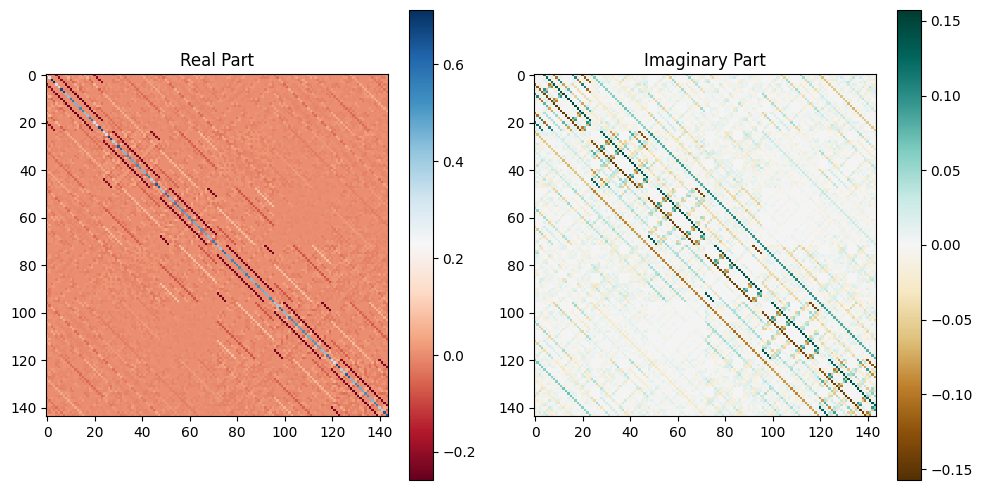

In [46]:
input_matrix = dataset[10009, 1, ...]
plot_complex_matrix(input_matrix)

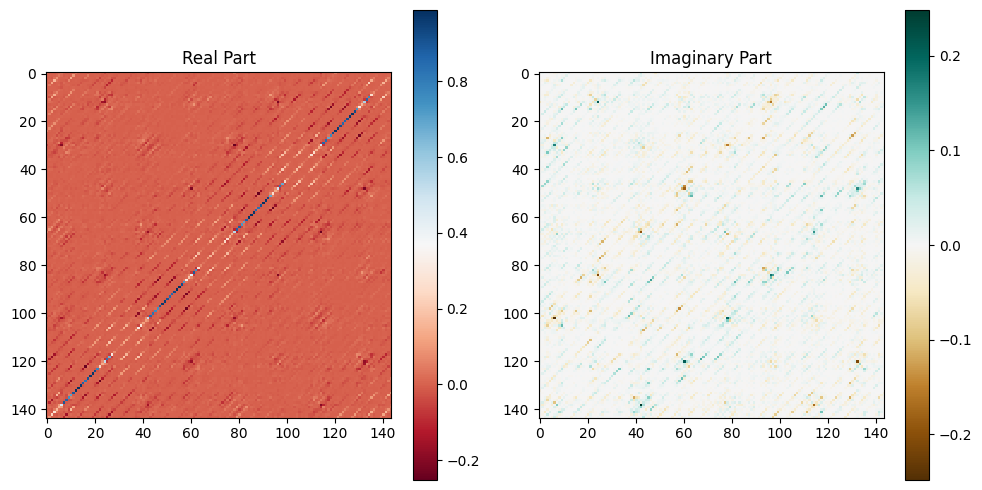

In [47]:
input_matrix = torch.fft.fft2(input_matrix, norm = "ortho")
plot_complex_matrix(input_matrix)

In [36]:
print(torch.max(input_matrix.real))

tensor(72.6608, dtype=torch.float64)


In [2]:
class HF_TransBreakingDataset(Dataset):
    def __init__(self, filename: str, indices: Tuple[int, int] = None) -> None:
        # load the data
        dataset = torch.load(filename)

        # get indices
        if indices is None:
            start_index = 0
            end_index = len(dataset)
        else:
            start_index = indices[0]
            end_index = indices[1]
        
        # split the dataset
        dataset = dataset[start_index : end_index, ...].to(dtype=torch.complex64)

        # now reshape to get it in the right form
        num_samples = dataset.shape[0]
        four_L_square = dataset.shape[-1]

        # check to make sure input is of correct shape
        assert (num_samples == end_index - start_index), "number of samples does not match indices internally"
        assert (dataset.shape[1] == 2), "second dimension must be of size 2"
        assert (dataset.shape[-2] == dataset.shape[-1] == four_L_square), "each matrix must be square with side length 4L^2"

        # find out what L is
        L_square = four_L_square // 4
        L = int(math.sqrt(L_square))

        # now reshape to (num_samples, 2, k_1_r, k_2_r, alpha_r, k_1_c, k_2_c, alpha_c)
        dataset = dataset.reshape(num_samples, 2, L, L, 4, L, L, 4)

        # now permute the dims to get (num_samples, 2, alpha_r, alpha_c, k_1_r, k_2_r, k_1_c, k_2_c)
        dataset = dataset.permute(0, 1, 4, 7, 2, 3, 5, 6)

        # now flatten each 4x4 block to eliminate the alpha indices
        dataset = dataset.reshape(num_samples, 2, 16, L, L, L, L)

        # finally, get input and output data
        self.initial_data = dataset[:, 0, ...]
        self.results_data = dataset[:, 1, ...]
    
    # function to return length of dataset
    def __len__(self):
        return self.initial_data.shape[0]
    
    # function to return an (input, output) pair from the dataset
    def __getitem__(self, index):
        x = self.initial_data[index]
        y = self.results_data[index]

        return {'x': x, 'y':y}

dataset = HF_TransBreakingDataset("/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_Trans_Breaking/trans_breaking_6x6_new.pt")
reshaped_matrix = dataset.__getitem__(10009)['y']
print(reshaped_matrix.shape)

torch.Size([16, 6, 6, 6, 6])


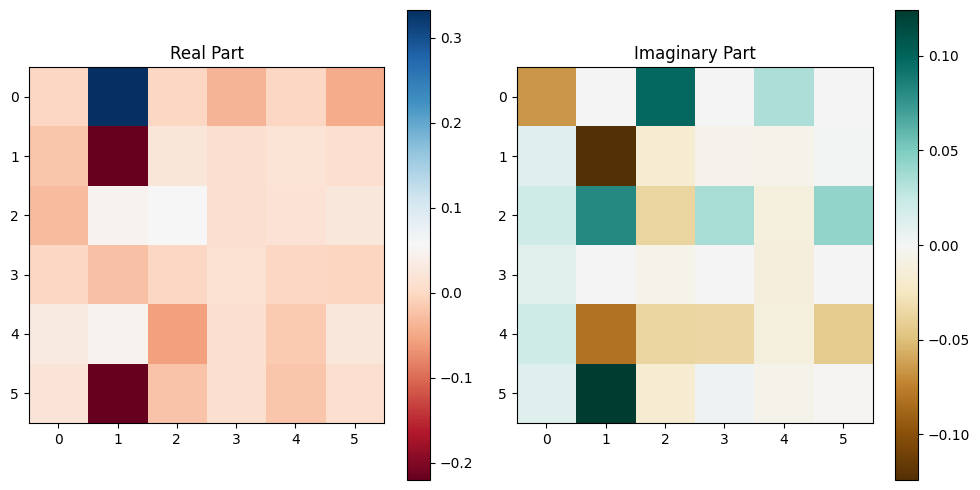

In [64]:
plot_complex_matrix(reshaped_matrix[0, 1, :, :, 0])

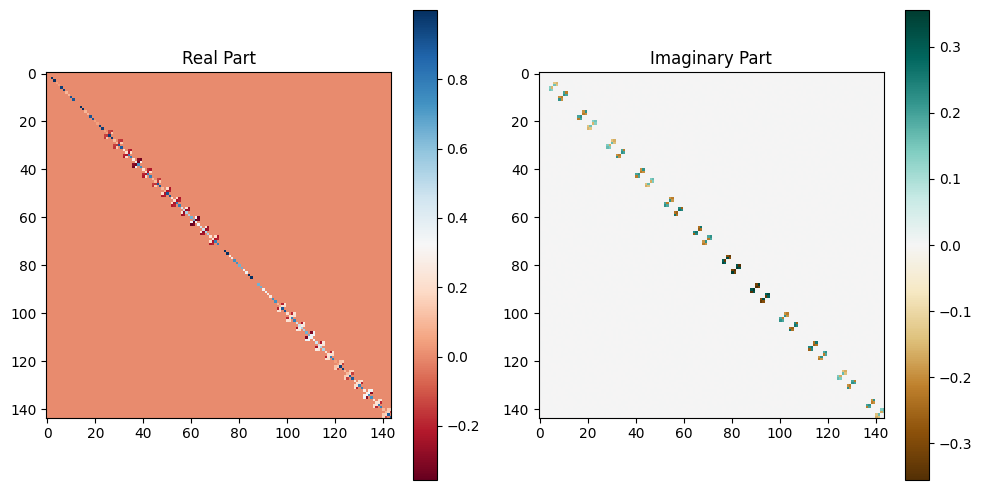

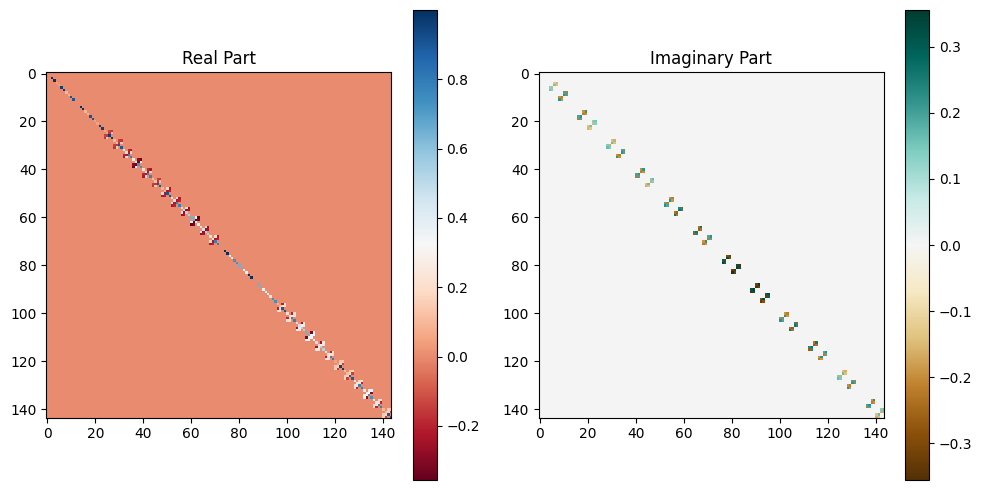

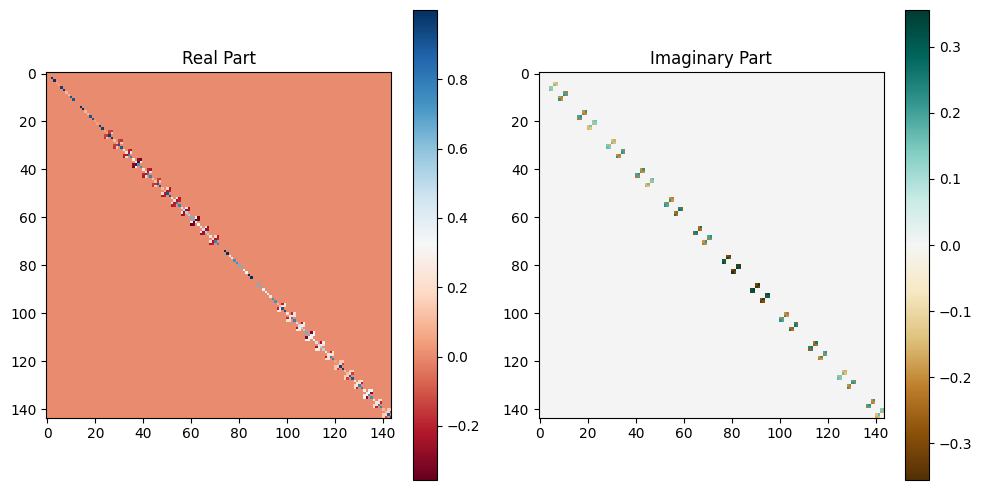

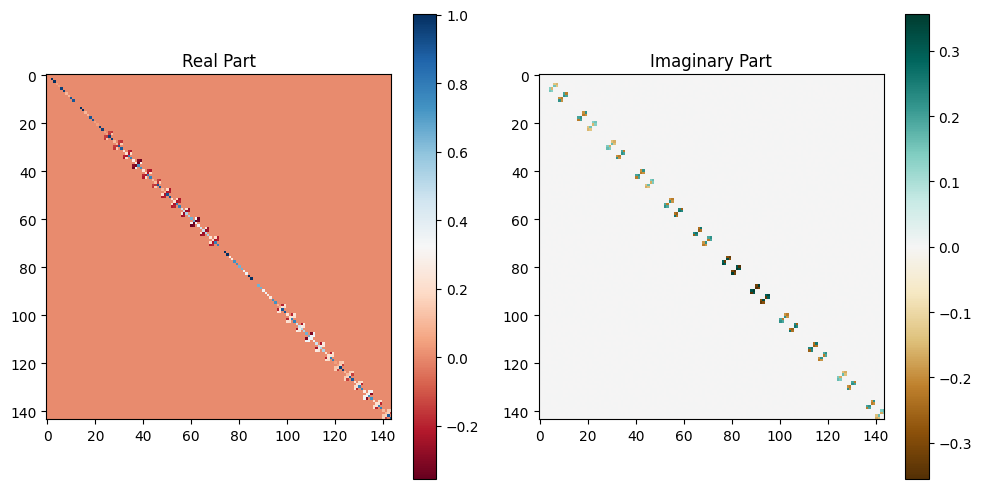

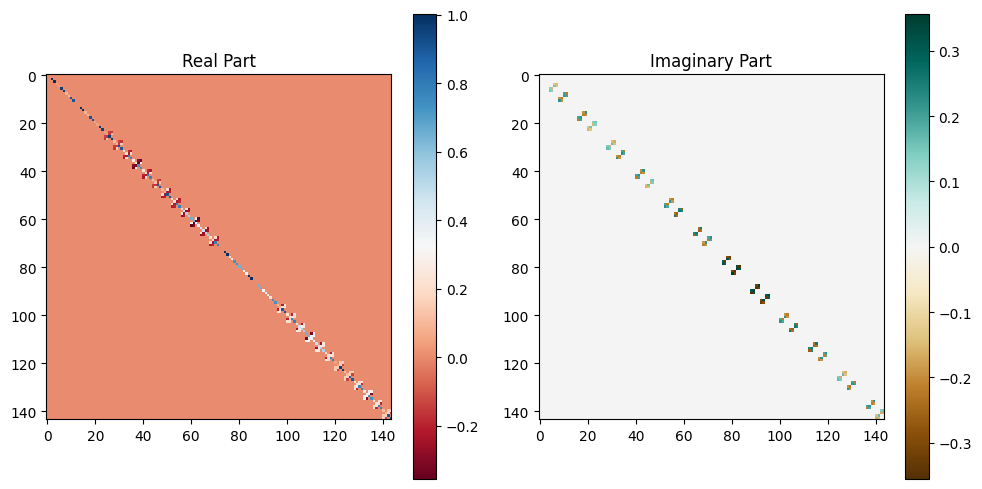

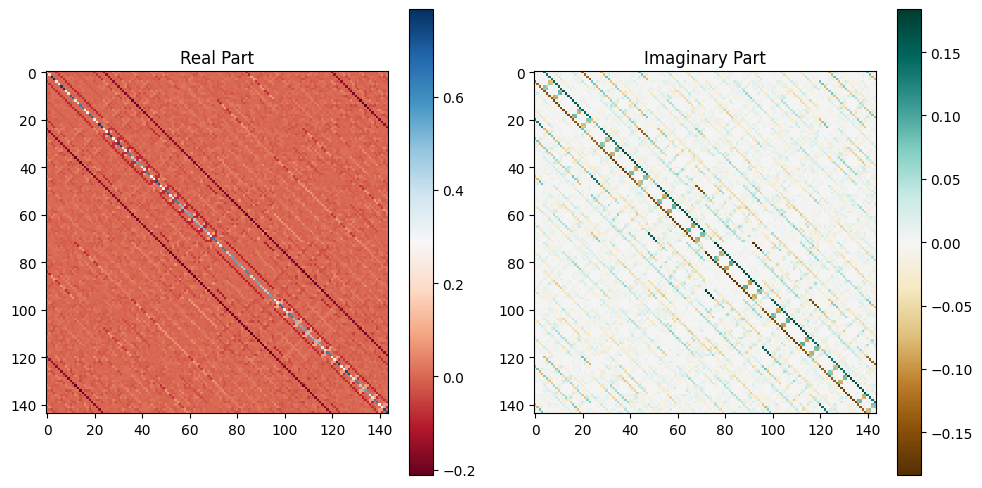

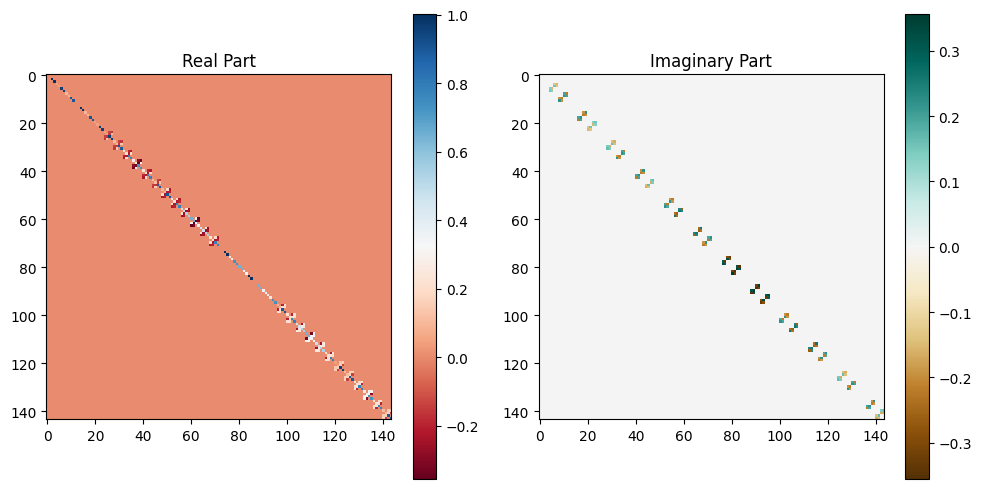

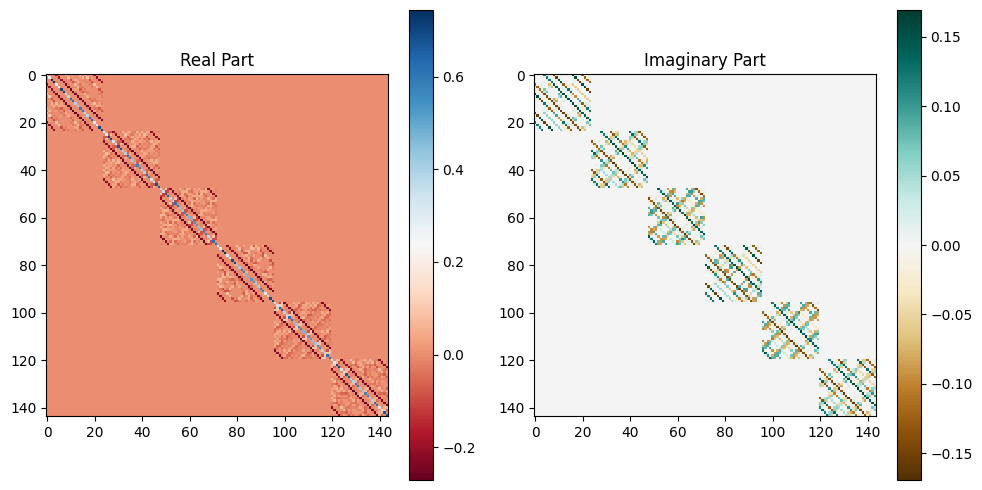

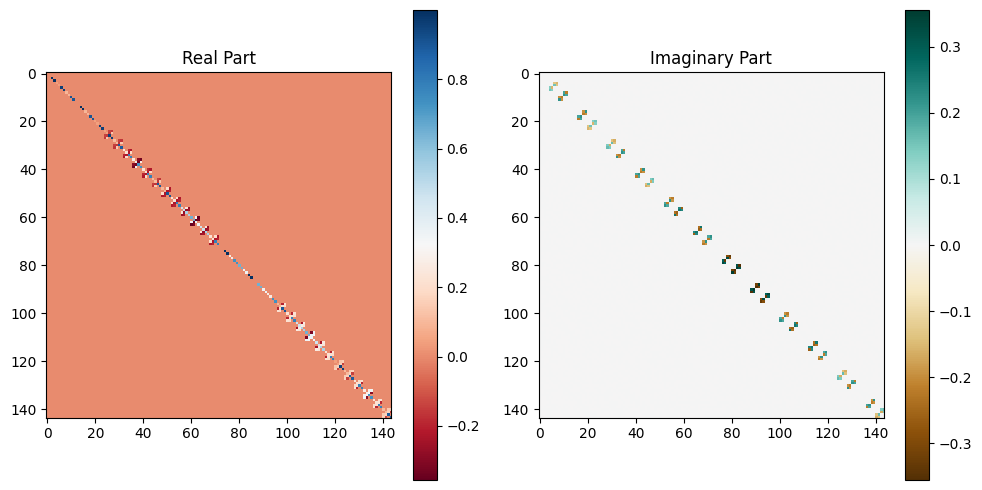

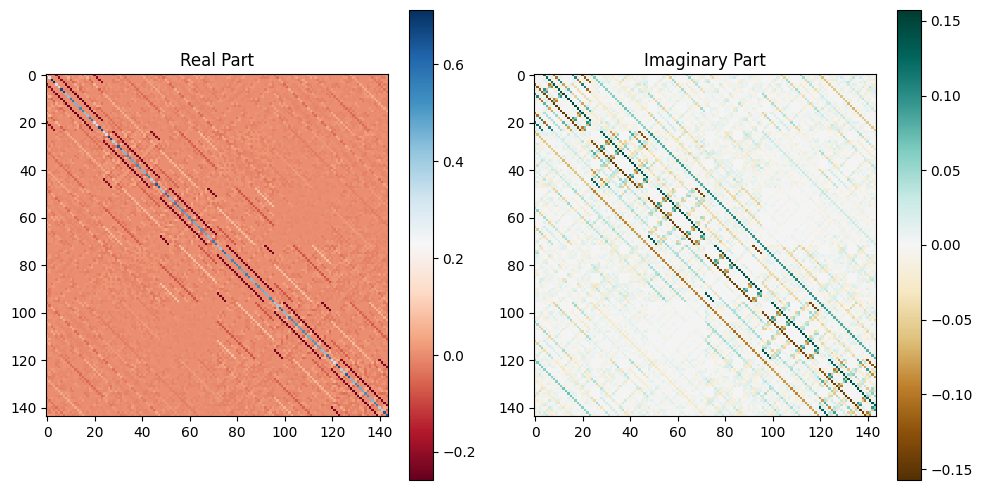

In [14]:
for pair in dataset[10000:10010, ...]:
    plot_complex_matrix(pair[1])

In [3]:
import neuralop

# positional embedding
grid_embedding = neuralop.layers.embeddings.GridEmbeddingND(in_channels = 16, dim = 4, grid_boundaries=[[0, 1], [0, 1], [0, 1], [0, 1]])

# instantiate the model
neural_operator = neuralop.models.FNO(n_modes = (16, 16, 16, 16), in_channels = 16, out_channels = 16, hidden_channels = 32, positional_embedding = grid_embedding, complex_data = True)
neural_operator.load_checkpoint("/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/FNO_test4_jun24/checkpoints", "neural_operator", map_location=torch.device('cpu'))

In [4]:
def reverse_transform(tensor: torch.Tensor) -> torch.Tensor:
    """
    Reverses the tensor transformations from the HF_TransBreakingDataset __init__
    method to return a tensor to its original 4L^2 x 4L^2 2D matrix format.

    The operations in the __init__ method are:
    1. Reshape from (..., 4L^2, 4L^2) to (..., L, L, 4, L, L, 4)
    2. Permute dimensions to group alphas and ks
    3. Reshape (flatten) the two 4x4 alpha dimensions into a single 16 dim

    This function reverses these steps in the opposite order.

    Args:
        tensor: A tensor from the dataset, i.e., x or y from __getitem__().
                Expected shape is (16, L, L, L, L).

    Returns:
        A torch.Tensor of shape (4L^2, 4L^2).
    """
    # --- Verify Input Tensor Shape ---
    if not isinstance(tensor, torch.Tensor):
        raise TypeError(f"Input must be a torch.Tensor, but got {type(tensor)}")
    if len(tensor.shape) != 5:
        raise ValueError(f"Input tensor must have 5 dimensions, but has {len(tensor.shape)}")
    if tensor.shape[0] != 16:
        raise ValueError(f"First dimension must be of size 16, but is {tensor.shape[0]}")
    if not (tensor.shape[1] == tensor.shape[2] == tensor.shape[3] == tensor.shape[4]):
        raise ValueError(f"Dimensions 1 through 4 (L) must be equal, but got shapes {tensor.shape[1:]}")

    # --- Determine L from the tensor shape ---
    L = tensor.shape[1]

    # --- Step 1: Reverse the flattening of the alpha indices ---
    # The original operation was:
    # dataset.reshape(num_samples, 2, 16, L, L, L, L)
    # This flattened the (alpha_r, alpha_c) dimensions of shape (4, 4).
    # We reverse this by reshaping the first dimension from 16 back to (4, 4).
    # Shape changes from (16, L, L, L, L) to (4, 4, L, L, L, L).
    # These dimensions correspond to the permuted order:
    # (alpha_r, alpha_c, k_1_r, k_2_r, k_1_c, k_2_c)
    tensor_unflattened = tensor.reshape(4, 4, L, L, L, L)

    # --- Step 2: Reverse the permutation ---
    # The original permutation was:
    # dataset.permute(0, 1, 4, 7, 2, 3, 5, 6)
    # For the 6 dimensions we are handling (after the sample and in/out dims),
    # this corresponds to moving from an original order of:
    # (k_1_r, k_2_r, alpha_r, k_1_c, k_2_c, alpha_c)
    # to a new order of:
    # (alpha_r, alpha_c, k_1_r, k_2_r, k_1_c, k_2_c)
    # We need to apply the inverse permutation to revert to the original order.
    # The inverse permutation for the 6 dimensions is (2, 3, 0, 4, 5, 1).
    tensor_unpermuted = tensor_unflattened.permute(2, 3, 0, 4, 5, 1)
    # Shape is now (L, L, 4, L, L, 4), corresponding to the order:
    # (k_1_r, k_2_r, alpha_r, k_1_c, k_2_c, alpha_c)

    # --- Step 3: Reverse the initial reshape ---
    # The original operation was:
    # dataset.reshape(num_samples, 2, L, L, 4, L, L, 4)
    # This reshaped the row and column dimensions (each of size 4L^2) of the
    # input matrix. The first three dimensions (L, L, 4) correspond to the rows,
    # and the last three (L, L, 4) correspond to the columns.
    # We can reverse this by reshaping these two groups of dimensions back into
    # a single dimension each.
    four_L_square = 4 * L**2
    matrix = tensor_unpermuted.reshape(four_L_square, four_L_square)
    # The final shape is (4L^2, 4L^2).

    return matrix

In [16]:
x = dataset.__getitem__(-1)['x'].unsqueeze(0)
with torch.no_grad():
    pred = neural_operator(x).squeeze(0)
y = dataset.__getitem__(-1)['y']

In [17]:
pred = reverse_transform(pred)
y = reverse_transform(y)
print(pred.shape)

torch.Size([144, 144])


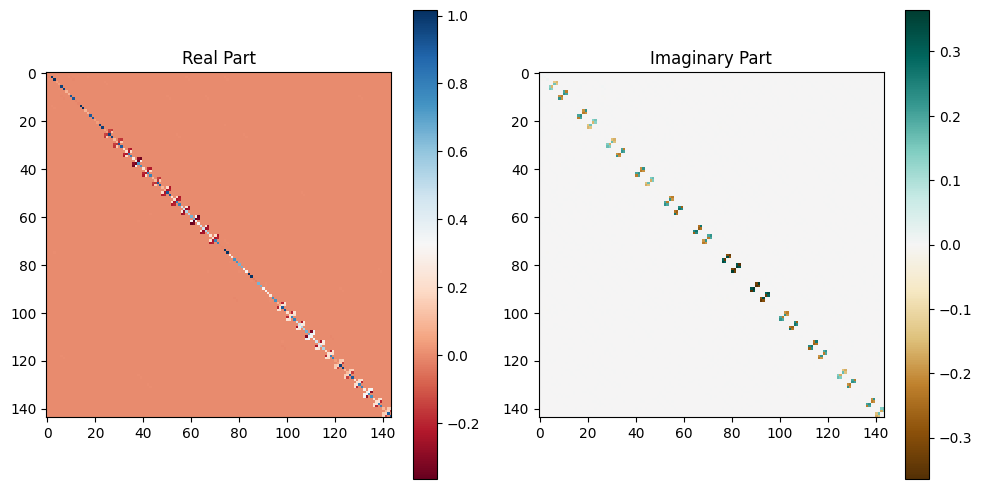

In [18]:
plot_complex_matrix(pred)

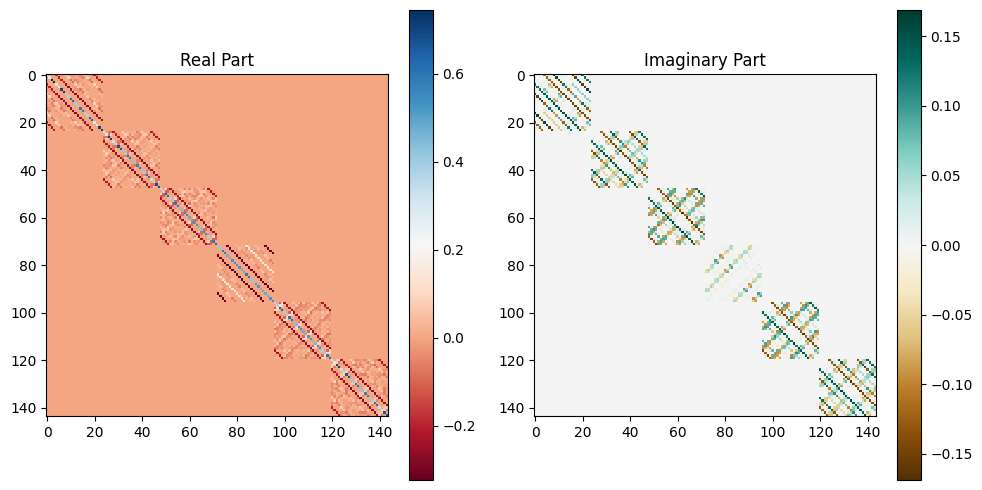

In [19]:
plot_complex_matrix(y)

In [42]:
def get_cutoff(sample: np.ndarray, tolerance: float = 0.95, num_steps = 126, DOF = 2) -> int:
    L_square = sample.shape[-1]
    side_length = sample.shape[0]
    for i in range(1, num_steps):
        cutoff = i * DOF
        norm = np.sum(np.abs(sample[:cutoff, :cutoff, :])**2)
        if (norm > tolerance * L_square):
            return cutoff
    return side_length

with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_9/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_9_unprojected_index_1/HF_results_data.h5", 'r') as f:
    for i in range(1, 10):
        print(f"Index: {i}")
        key = str(i)
        data = f[key]['OP_list_plane_wave'][()]
        cutoff = get_cutoff(data)
        print(f"Cutoff: {cutoff}")

Index: 1
Cutoff: 198
Index: 2
Cutoff: 198
Index: 3
Cutoff: 198
Index: 4
Cutoff: 198
Index: 5
Cutoff: 198
Index: 6
Cutoff: 198
Index: 7
Cutoff: 198
Index: 8
Cutoff: 198
Index: 9
Cutoff: 198


In [9]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_6/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_unprojected_index_1/HF_results_data.h5", 'r') as f:
    matrix = np.transpose(f['1']['OP_list_plane_wave'][()][:, :, 1])
    print(matrix.shape)
    i_Q = []
    for i in range(126):
        prob = np.abs(matrix[2*i, 2*i] + matrix[(2*i)+1, (2*i)+1])
        i_Q.append((prob, i))


    # --- Step 3: Sort the list and get the top 6 ---
    # We use the built-in sorted() function.
    # - The 'key' tells sorted() to use the first element of each tuple (the value) for sorting.
    # - 'reverse=True' sorts from highest to lowest.
    sorted_values = sorted(i_Q, key=lambda item: item[0], reverse=True)

    # Slice the list to get only the top 6 pairs
    top_6_pairs = sorted_values[:6]


    # --- Step 4: Extract the indices ---
    # Create a final list containing only the index from each of the top pairs.
    top_6_indices = [index for value, index in top_6_pairs]

print(top_6_indices)

(252, 252)
[28, 98, 36, 89, 27, 97]


In [ ]:
i_Q = 2*np.array(top_6_indices)
print(i_Q)

[ 54  56  72 178 194 196]


In [4]:
indices = []
for i in i_Q:
    for j in i_Q:
        indices.append(np.array([i, j]))
indices = np.array(indices)
print(indices)

[[ 54  54]
 [ 54  56]
 [ 54  72]
 [ 54 178]
 [ 54 194]
 [ 54 196]
 [ 56  54]
 [ 56  56]
 [ 56  72]
 [ 56 178]
 [ 56 194]
 [ 56 196]
 [ 72  54]
 [ 72  56]
 [ 72  72]
 [ 72 178]
 [ 72 194]
 [ 72 196]
 [178  54]
 [178  56]
 [178  72]
 [178 178]
 [178 194]
 [178 196]
 [194  54]
 [194  56]
 [194  72]
 [194 178]
 [194 194]
 [194 196]
 [196  54]
 [196  56]
 [196  72]
 [196 178]
 [196 194]
 [196 196]]


In [6]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_9/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_9_unprojected_index_1/HF_results_data.h5", 'r') as f:
    array = np.transpose(f['1']['OP_list_plane_wave'][()])
    print(array.shape)

pieces = []
for index in indices:
    i = index[0]
    j = index[1]
    pieces.append(array[:, i:i+2, j:j+2].reshape(81, -1))
array = np.concatenate(pieces, axis = -1)

(81, 252, 252)


In [7]:
print(array.shape)

(81, 144)


In [12]:
probability = 0
for index in indices:
    i = index[0]
    j = index[1]
    probability += np.abs(np.sum(matrix[i:i+1, j:j+1]))
print(probability)

5.906584902358018


In [67]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_FH_3.89deg_data_for_HF.h5", 'r') as f:
    Qset = f['Qset'][()]
print(Qset.shape)

(126, 2)


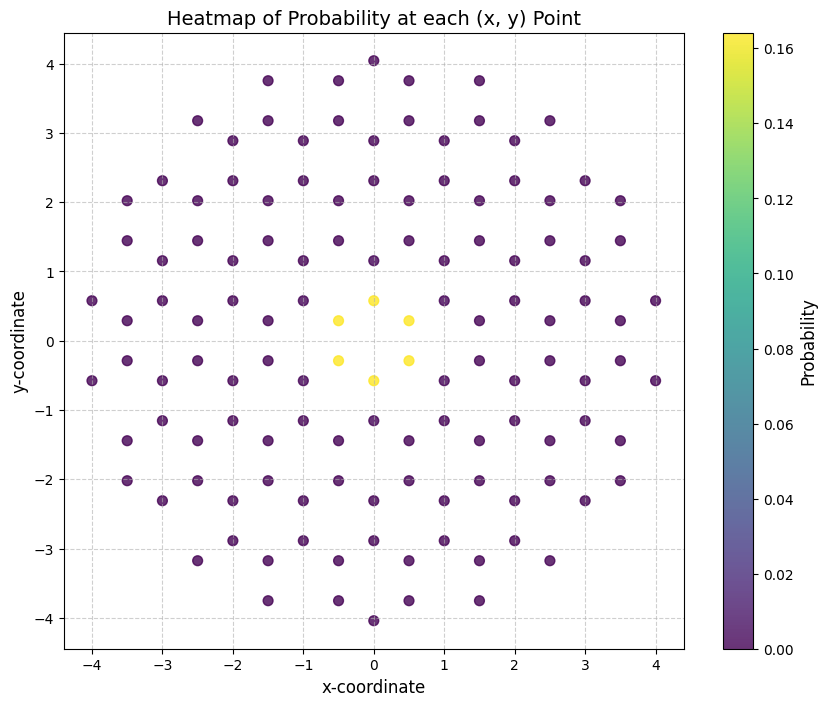

In [71]:
# Plot the function
x = Qset[:, 0]
y = Qset[:, 1]

probabilities = []
for i in range(126):
    probabilities.append(np.abs(matrix[2*i, 2*i] + matrix[(2*i)+1, (2*i)+1]))

# 3. Create the plot
# Set up the figure size
plt.figure(figsize=(10, 8))

# Create the scatter plot, using 'c' to map probabilities to color
# 'cmap' sets the color scheme (e.g., 'viridis', 'plasma', 'hot', 'coolwarm')
scatter = plt.scatter(x, y, c=probabilities, cmap='viridis', s=50, alpha=0.8)

# 4. Add plot elements for clarity
# Add a color bar to show the mapping of colors to probability values
colorbar = plt.colorbar(scatter)
colorbar.set_label('Probability', fontsize=12)

# Add labels and a title
plt.xlabel('x-coordinate', fontsize=12)
plt.ylabel('y-coordinate', fontsize=12)
plt.title('Heatmap of Probability at each (x, y) Point', fontsize=14)

# Add a grid for easier reading of coordinates
plt.grid(True, linestyle='--', alpha=0.6)

# Display the plot
plt.show()

### Code to process datasets

In [67]:
with h5py.File("/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_18_y_18_f1_1_0_f2_0_1_xrefine_18_yrefine_18_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_96/Momenta_and_eigenvecs.h5", 'r') as f:
    BZindex_refine = f['BZindex_refine'][()]
    BZindex_refine = np.transpose(BZindex_refine)
    # min_err = float('inf')
    # index = -1
    # for i in range(BZindex_refine.shape[0]):
    #     x, y = BZindex_refine[i]
    #     diff = np.sqrt(((x - (1/3))**2) + ((y - (1/3))**2))
    #     if diff < min_err:
    #         min_err = diff
    #         index = i
    # print(index)
    # print(BZindex_refine[index])
    print(BZindex_refine[261])

[ 0.33333333 -0.66666667]


In [21]:
def analyze_precision(h5_file_path, num_samples=1):
    with h5py.File(h5_file_path, 'r') as f:
        glob_max = 0
        glob_mean = 0
        for i in range(1, num_samples + 1):
            data = f[str(i)]['OP_list'][()].real
            if data.any() != 0:
                print("False")
            # Compute relative error from float64 to float32
            data32 = data.astype(np.float32)
            rel_error = np.abs(data - data32) / np.maximum(np.abs(data), 1e-12)
            local_max = np.max(rel_error)
            if local_max > glob_max:
                glob_max = local_max
            
            local_mean = np.mean(rel_error)
            glob_mean += local_mean
        
        glob_mean /= num_samples

        print(f"Max relative error from float64 to float32: {glob_max:.2e}")
        print(f"Mean relative error: {glob_mean:.2e}")
        
        if glob_max < 1e-6:
            print("float32 is likely sufficient.")
        else:
            print("float64 may be necessary to preserve precision.")

# Example usage
analyze_precision('/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_6_y_6_f1_1_0_f2_0_1_xrefine_6_yrefine_6_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8_10K/HF_results_data.h5')

False
Max relative error from float64 to float32: 5.45e-08
Mean relative error: 2.09e-08
float32 is likely sufficient.


In [41]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_6/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_6_unprojected_index_41/HF_results_data.h5", 'r') as f:
    dataset = f['1']["OP_list_plane_wave"][()]
print(dataset.shape)
print(dataset.dtype)

(252, 252, 36)
complex128


In [ ]:
# helper function to process LxL nxn matrices
def make_nxn_matrix(array: np.ndarray, U_parallel_transport_tab: np.ndarray = None, f: List[int] = None, truncated = False, indices = None) -> np.ndarray:
    # input should be of shape (n, n, LxL)
    # first transpose to get (LxL, n, n)
    array = np.transpose(array)
    L_square = array.shape[0]

    # truncate the matrix if needed
    if truncated is True:
        pieces = []
        for index in indices:
            i = index[0]
            j = index[1]
            pieces.append(array[:, i:i+2, j:j+2].reshape(L_square, -1))
        array = np.concatenate(pieces, axis = -1)
    else:
        # do the transformation to smooth basis if needed
        if (U_parallel_transport_tab is not None) and (f is not None):
            OP_list = array
            smooth_OP_list = np.zeros_like(OP_list)
            for j in range(L_square):
                smooth_OP_list[j, :, :] = np.transpose(U_parallel_transport_tab[f[j], :, :]) @ OP_list[j, :, :] @ np.conjugate(U_parallel_transport_tab[f[j], :, :])
            array = smooth_OP_list
    
        # array should still be of shape (LxL, n, n)
        array = array.reshape(L_square, -1)
    
    # finally, combine the real and imaginary parts
    array = np.concatenate([array.real, array.imag], axis=-1, dtype=np.float32)
    
    # combine the matrices into one array
    return array


# function to parse the .h5 files from the 3x3 code into a dataset
def parse_3x3_dataset(input_filename: str, output_filename: str, dataset_loc: str, num_samples = -1, matrix_dim=3):

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        # get number of samples
        if (num_samples == -1):
            num_samples = len(list(in_file.keys()))
        with h5py.File(output_filename, "r") as out_file:
            # first get seq_len
            seq_len = out_file['1']['OP_list'][()].shape[-1]
            with h5py.File(dataset_loc, "w") as f:
                embed_dim = 2 * (matrix_dim ** 2)
                f.create_dataset(name="dataset", shape=(num_samples, 2, seq_len, embed_dim), dtype=np.float32)
                for i in range(1, num_samples + 1):
                    print(f"\rIndex: {i}", end='', flush=True)
                    try:
                        f['dataset'][i-1] = np.array(
                                [
                                    make_nxn_matrix(in_file[str(i)]['OP_list'][()]),
                                    make_nxn_matrix(out_file[str(i)]['OP_list'][()]),
                                ]
                            )
                    except (KeyError, OSError, IndexError) as e:
                        print(f"Error reading {i}: {e}")
                        continue

# wrapper function to make life easier
"""
def preprocessing(L, folder_name, num_samples):
    print(f"Starting {L}x{L} dataset:")
    parse_3x3_dataset(
        input_filename=f"/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/{folder_name}/HF_initial_data.h5",
        output_filename=f"/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/{folder_name}/HF_results_data.h5",
        dataset_loc=f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/3x3_model/dataset_{L}x{L}_{num_samples / 1000}K.h5",
        num_samples=num_samples
    )
    print("Done!\n")
"""

In [ ]:
# function to reformat output into a sequence of nxn matrices
def reformat_nxn_matrix(array: np.ndarray):
    # input should be of shape (L^2, 2n^2)
    n_square = array.shape[-1] // 2
    # first, convert back to complex
    real_part = array[:, :n_square]
    imag_part = array[:, n_square:]
    array = real_part + (1j * imag_part)
    array = array.astype(np.complex128)

    # array should now be complex of shape (L^2, n^2)
    # need to reshape to (n, n, L^2)
    L_square = array.shape[0]
    n = int(math.sqrt(n_square))
    array = array.reshape(L_square, n, n)
    array = np.transpose(array)
    
    return array

In [ ]:
# function to parse the .h5 files from the unprojected HF code into a dataset
def parse_unprojected_dataset(input_filename: str, output_filename: str, dataset_loc: str, cutoff = 70, num_samples = -1):

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        # get number of samples
        if (num_samples == -1):
            num_samples = len(list(in_file.keys()))
        with h5py.File(output_filename, "r") as out_file:
            # first get seq_len
            seq_len = out_file['1']['OP_list_plane_wave'][()].shape[-1]
            with h5py.File(dataset_loc, "w") as f:
                embed_dim = (cutoff ** 2) * 2
                f.create_dataset(name="dataset", shape=(num_samples, 2, seq_len, embed_dim), dtype=np.float32)
                for i in range(1, num_samples + 1):
                    print(f"\rIndex: {i}", end='', flush=True)
                    try:
                        f['dataset'][i-1] = np.array(
                                [
                                    make_nxn_matrix(in_file[str(i)]['OP_list_plane_wave'][()], cutoff=cutoff),
                                    make_nxn_matrix(out_file[str(i)]['OP_list_plane_wave'][()], cutoff=cutoff),
                                ]
                            )
                    except (KeyError, OSError, IndexError) as e:
                        print(f"Error reading {i}: {e}")
                        continue

In [ ]:
# function to do the same but return as a numpy array instead
def parse_nxn_dataset_ndarray(io_filenames: Tuple[str, str], num_samples = -1, smoothen = False, key: str = 'OP_list', cutoff = None):
    # io_filenames should be a tuple of (input_filename, output_filename)
    input_filename, output_filename = io_filenames

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        # get number of samples
        if (num_samples == -1):
            num_samples = len(list(in_file.keys()))
        with h5py.File(output_filename, "r") as out_file:
            # first get seq_len
            seq_len = out_file['1'][key][()].shape[-1] # type: ignore
            # seq_len is equal to L^2
            if smoothen is True:
                # now we have to find f(j)
                folders = {
                    9: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_3_y_3_f1_1_0_f2_0_1_xrefine_3_yrefine_3_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8_train",
                    36: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_6_y_6_f1_1_0_f2_0_1_xrefine_6_yrefine_6_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8",
                    81: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_9_y_9_f1_1_0_f2_0_1_xrefine_9_yrefine_9_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8",
                    144: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_12_y_12_f1_1_0_f2_0_1_xrefine_12_yrefine_12_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8",
                    225: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8",
                    324: "MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_18_y_18_f1_1_0_f2_0_1_xrefine_18_yrefine_18_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_96"
                }
                momenta_and_eigenvecs_file = f"/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/{folders[seq_len]}/Momenta_and_eigenvecs.h5"

                with h5py.File(momenta_and_eigenvecs_file, 'r') as momenta_and_eigenvecs:
                    BZindex_refine_L = momenta_and_eigenvecs['BZindex_refine'][()]
                    # convert to Python shape
                    BZindex_refine_L = np.transpose(BZindex_refine_L)
                    # should be of shape (L^2, 2)
                
                # also need BZ_index_refine_180
                with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_CN_n+n_2DInt_HF_MatElement_k_shfit_JY_Band_Projected_HF_Generate_Eigenvecs/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_180_y_180_f1_1_0_f2_0_1_xrefine_180_yrefine_180_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000/Momenta_and_eigenvecs.h5", 'r') as momenta_and_eigenvecs:
                    BZindex_refine_180 = momenta_and_eigenvecs['BZindex_refine'][()]
                    # convert to Python shape
                    BZindex_refine_180 = np.transpose(BZindex_refine_180)
                    # should be of shape (180^2, 2)
                
                f = []
                for j in range(seq_len):
                    momentum = BZindex_refine_L[j]
                    min_err = float('inf')
                    index = -1
                    
                    for f_j in range(180**2):
                        error = np.sqrt(np.sum((momentum - BZindex_refine_180[f_j]) ** 2))
                        if (error < min_err):
                            min_err = error
                            index = f_j
                    
                    f.append(index)
                
                # also need U_parallel_transport_tab
                with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_CN_n+n_2DInt_HF_MatElement_k_shfit_JY_Band_Projected_HF_Generate_Eigenvecs/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_180_y_180_f1_1_0_f2_0_1_xrefine_180_yrefine_180_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000/Eigenvecs_smooth.h5", 'r') as eigenvecs_smooth:
                    U_parallel_transport_tab = eigenvecs_smooth['U_parallel_transport_tab'][()]
                    # convert to Python shape
                    U_parallel_transport_tab = np.transpose(U_parallel_transport_tab)
            else:
                U_parallel_transport_tab = None
                f = None

            # now we can finally compute
            vector_list = []
            for i in range(1, num_samples + 1):
                print(f"\rIndex: {i}", end='', flush=True)
                try:
                    vector_list.append(np.array(
                            [
                                make_nxn_matrix(in_file[str(i)][key][()], U_parallel_transport_tab, f, cutoff = cutoff),
                                make_nxn_matrix(out_file[str(i)][key][()], U_parallel_transport_tab, f, cutoff = cutoff),
                            ]
                        ))
                except (KeyError, OSError, IndexError) as e:
                    print(f"Error reading {i}: {e}")
                    continue
    
    vector_list = np.array(vector_list, dtype=np.float32)
    return vector_list

**Transforming to smooth eigenbasis**

In [35]:
def plot_matrix_heatmaps(
    matrix_array: np.ndarray,
    show_values: bool = True,
    figsize_per_row: tuple[int, int] = (6, 3),
    cmap: str = 'seismic'
) -> None:
    """
    Generates a vertical stack of heatmaps for a series of 3x3 complex matrices.

    For each matrix, it creates two side-by-side heatmaps: one for the real part
    and one for the imaginary part. This version correctly places the colorbar.

    Args:
        matrix_array: A NumPy array of complex numbers with shape (L^2, 3, 3).
        show_values: If True, displays the numerical value in each heatmap cell.
        figsize_per_row: The figure size allocated for each row of heatmaps.
                         The final figure height will be L^2 * figsize_per_row[1].
        cmap: The colormap to use for the heatmaps. A "diverging" colormap like
              'seismic' (Blue-White-Red) or 'bwr' is recommended.
    """
    # --- 1. Data Validation and Preparation ---
    if matrix_array.ndim != 3 or matrix_array.shape[1:] != (3, 3):
        raise ValueError("Input array must have shape (L^2, 3, 3)")

    L_square = matrix_array.shape[0]
    real_parts = np.real(matrix_array)
    imag_parts = np.imag(matrix_array)

    global_min = min(real_parts.min(), imag_parts.min())
    global_max = max(real_parts.max(), imag_parts.max())
    abs_max = max(abs(global_min), abs(global_max))
    vmin, vmax = -abs_max, abs_max

    # --- 2. Figure Setup ---
    fig_width = figsize_per_row[0]
    fig_height = L_square * figsize_per_row[1]
    
    fig, axes = plt.subplots(
        nrows=L_square,
        ncols=2,
        figsize=(fig_width, fig_height),
        squeeze=False
    )

    # --- 3. Plotting Loop ---
    # This part remains the same
    for i in range(L_square):
        ax_real, ax_imag = axes[i, 0], axes[i, 1]
        
        im_real = ax_real.imshow(real_parts[i], cmap=cmap, vmin=vmin, vmax=vmax)
        ax_imag.imshow(imag_parts[i], cmap=cmap, vmin=vmin, vmax=vmax)
        ax_real.set_ylabel(f"Matrix {i}", fontsize=12, rotation=0, labelpad=40)

        if show_values:
            for ax, data in zip([ax_real, ax_imag], [real_parts[i], imag_parts[i]]):
                for r in range(3):
                    for c in range(3):
                        ax.text(c, r, f"{data[r, c]:.2f}",
                                ha="center", va="center", color="black", fontsize=10)

    # --- 4. Formatting and Layout (Revised to fix colorbar overlap) ---
    
    # Set titles for the two columns on the topmost plots
    axes[0, 0].set_title("Real Part", fontsize=14)
    axes[0, 1].set_title("Imaginary Part", fontsize=14)

    # Configure ticks for all subplots
    for ax in axes.flat:
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(3))
        ax.tick_params(labelbottom=False, labelleft=False)
    
    for ax in axes[-1, :]:
        ax.tick_params(labelbottom=True)
    for ax in axes[:, 0]:
        ax.tick_params(labelleft=True)

    # Manually adjust the subplot layout to make room for the colorbar
    # This tells the subplots to occupy the left 85% of the figure area
    fig.subplots_adjust(right=0.85, hspace=0.3)

    # Add a new axis for the colorbar in the space we just created
    # The arguments are [left, bottom, width, height] in figure coordinates
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    
    # Draw the colorbar in the new, dedicated axis
    fig.colorbar(im_real, cax=cbar_ax)

    plt.show()

In [39]:
vector_list = parse_3x3_dataset_ndarray(("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_CN_n+n_2DInt_HF_MatElement_k_shfit_JY_Band_Projected_HF/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_18_y_18_f1_1_0_f2_0_1_xrefine_18_yrefine_18_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_index_1/HF_initial_data.h5",
                          "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_CN_n+n_2DInt_HF_MatElement_k_shfit_JY_Band_Projected_HF/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_18_y_18_f1_1_0_f2_0_1_xrefine_18_yrefine_18_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_index_1/HF_results_data.h5"),
                          num_samples=1)
print(vector_list.shape)

Index: 1(1, 2, 324, 18)


In [45]:
real_part = vector_list[0, 1, :, :9]
imag_part = vector_list[0, 1, :, 9:]
sample_output = (real_part + (1j * imag_part)).reshape(324, 3, 3)
print(sample_output.shape)

(324, 3, 3)


In [3]:
def plot_real_part_on_2d_grid_2d(
    complex_array: np.ndarray,
    coordinates: np.ndarray,
    figsize: tuple[int, int] = (10, 8),
    title: str = "Real Part of Complex Tensor on 2D Coordinate Grid",
    cmap: str = 'viridis'
) -> None:
    """
    Plots the real part of a complex array as a 2D scatter plot.

    The position of each point is determined by the `coordinates` array,
    and the color of each point is determined by the real part of the
    corresponding element in the `complex_array`.

    Args:
        complex_array: A 1D NumPy array of complex numbers.
        coordinates: A 2D NumPy array of shape (n, 2) where n is the length
                     of complex_array. The columns represent the (x, y)
                     coordinates.
        figsize: The size of the matplotlib figure.
        title: The title for the plot.
        cmap: The colormap to use for the scatter plot.
    """
    # --- 1. Data Validation and Preparation ---
    if complex_array.ndim != 1:
        raise ValueError("Input `complex_array` must be 1-dimensional.")
    if coordinates.ndim != 2 or coordinates.shape[1] != 2:
        raise ValueError("Input `coordinates` must have shape (n, 2).")
    if len(complex_array) != coordinates.shape[0]:
        raise ValueError(
            "Length of `complex_array` must match the number of rows in `coordinates`."
        )

    # Extract the components for plotting
    x_coords = coordinates[:, 0]
    y_coords = coordinates[:, 1]
    colors = complex_array.real # The color is determined by the real part

    # --- 2. 2D Plotting Setup ---
    fig, ax = plt.subplots(figsize=figsize)

    # --- 3. Create the Scatter Plot ---
    scatter = ax.scatter(
        x_coords,
        y_coords,
        c=colors,
        cmap=cmap,
        marker='o'
    )

    # --- 4. Set Labels and Title ---
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title(title, fontsize=16, pad=20)

    # Add a color bar that represents the value of the real part
    fig.colorbar(scatter, ax=ax, label='Real Part Value')

    # Improve aesthetics
    ax.set_aspect('equal', adjustable='box') # Make the plot square
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

In [19]:
list_p = sample_output[:, 1, 1]
plot_real_part_on_2d_grid_2d(complex_array=list_p, coordinates=BZindex_refine)

NameError: name 'sample_output' is not defined

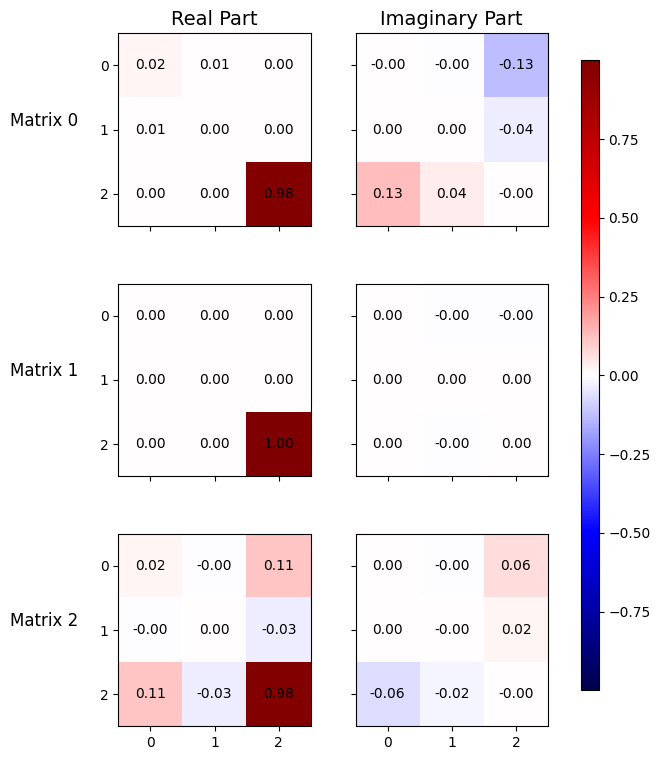

In [ ]:
plot_matrix_heatmaps(sample_output[260:263])

(9, 2)
float64


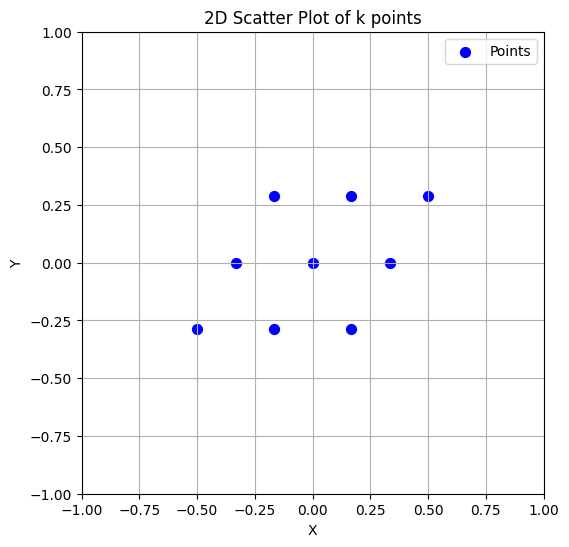

(36, 2)
float64


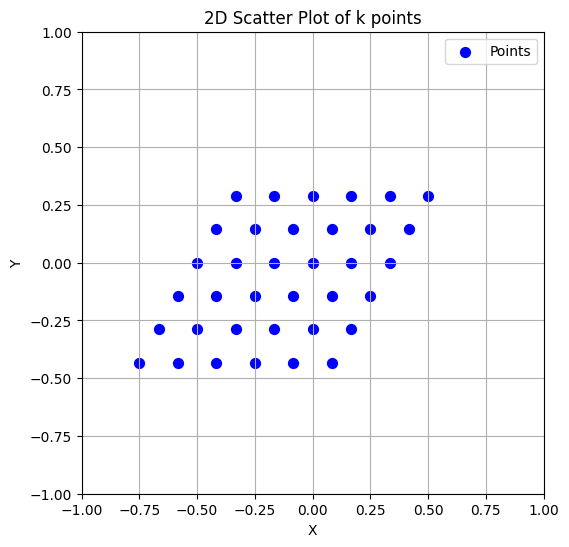

(81, 2)
float64


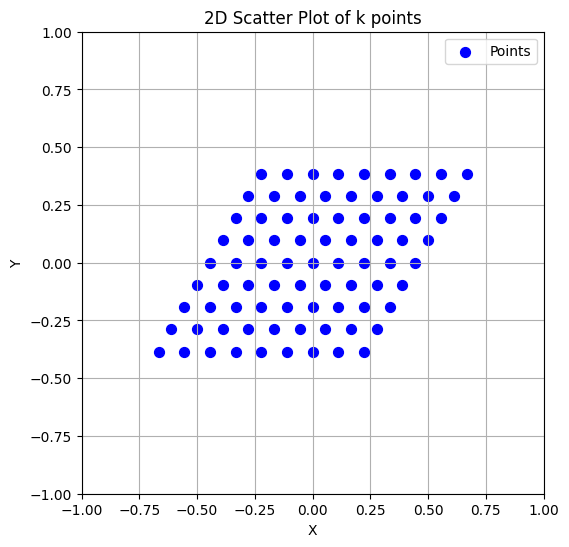

(144, 2)
float64


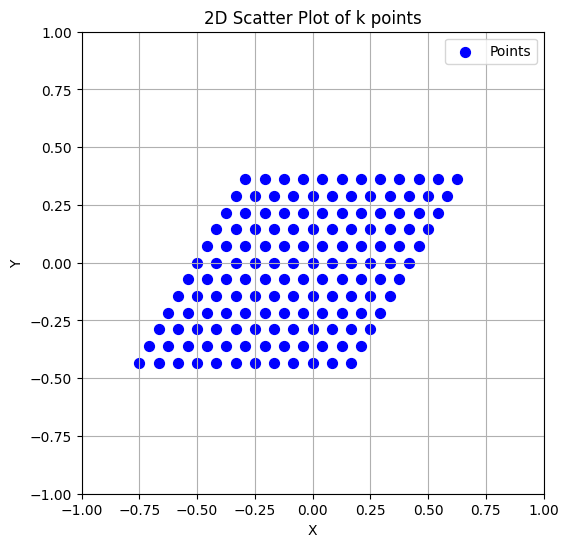

(225, 2)
float64


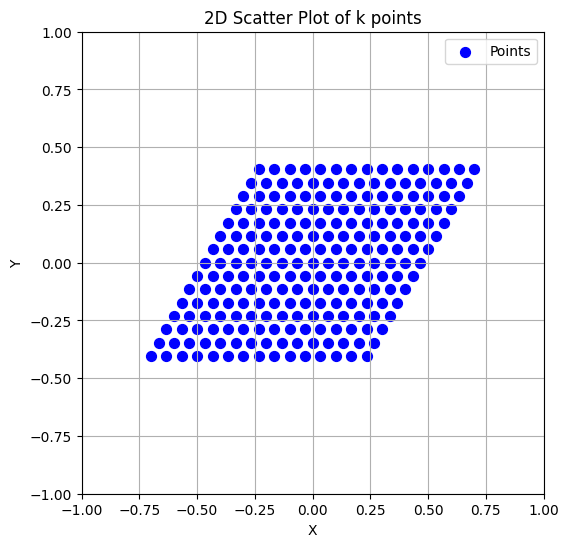

(324, 2)
float64


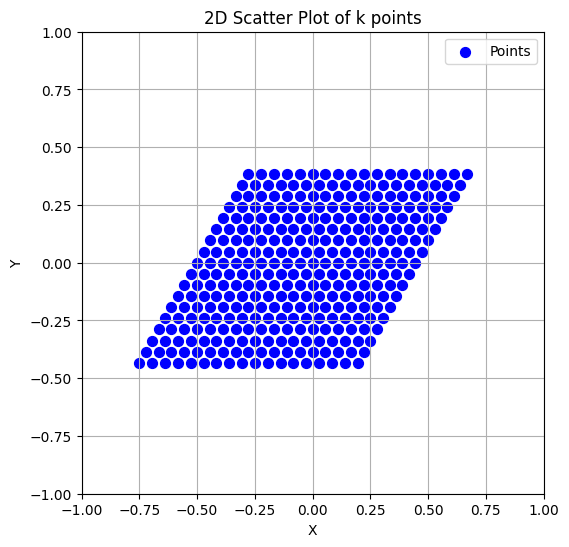

In [4]:
def get_positional_embeddings(L: int):
    SP_MkqTab_IntHartree_IntFock_file = f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_{L}/setup/Set_up_folder_L_{L}_index_1/SP_MkqTab_IntHartree_IntFock_data.h5"

    # add each group of matrices to the list
    with h5py.File(SP_MkqTab_IntHartree_IntFock_file, "r") as f:
        BZindex = f['BZindex'][()]

    BZindex = np.transpose(BZindex)
    print(BZindex.shape)
    print(BZindex.dtype)

    # convert to true_momentum
    L_square = BZindex.shape[0]
    true_momentum = np.zeros((L_square, 2))
    for i in range(L_square):
        true_momentum[i] = np.array([
            BZindex[i, 0] + (0.5 * BZindex[i, 1]),
            (np.sqrt(3) / 2) * BZindex[i, 1]
        ])

    # plot the positions

    # Extract x and y coordinates
    x = true_momentum[:, 0]
    y = true_momentum[:, 1]

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', s=50, label='Points')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    # Enforce 1:1 aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

    # Customize plot
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('2D Scatter Plot of k points')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

    true_momentum = torch.from_numpy(true_momentum).to(dtype=torch.float32)
    torch.save(true_momentum, f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tMoTe2_model/true_momentum_{L}x{L}.pt")
    return true_momentum

for L in range(3, 19, 3):
    get_positional_embeddings(L)

In [5]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_18/setup/Set_up_folder_L_18_index_1/SP_MkqTab_IntHartree_IntFock_data.h5", "r") as f:
        BZindex = np.transpose(f['BZindex'][()])
print(BZindex.shape)

(324, 2)


In [6]:
true_momentum = []
for v in BZindex:
    k = np.array([
        v[0] + (0.5 * v[1]),
        (np.sqrt(3) / 2) * v[1]
    ])
    true_momentum.append(k)
true_momentum = np.array(true_momentum)
print(true_momentum.shape)
print(true_momentum.dtype)

(324, 2)
float64


In [7]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_18/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_18_index_1/HF_results_data.h5") as f:
    OP_list = np.transpose(f['1']['OP_list'][()])
print(OP_list.shape)

(324, 4, 4)


In [16]:
new_momentum = np.concatenate([
    true_momentum + np.array([0, 0]),
    true_momentum + np.array([1, 0]),
    true_momentum + np.array([-1, 0]),
    true_momentum + np.array([-0.5, -np.sqrt(3)/2]),
    true_momentum + np.array([0.5, -np.sqrt(3)/2]),
    true_momentum + np.array([-1.5, -np.sqrt(3)/2]),
], axis = 0)

new_vals = np.tile(np.abs(OP_list[:, 0, 0]), (6))

In [17]:
new_momentum.shape

(1944, 2)

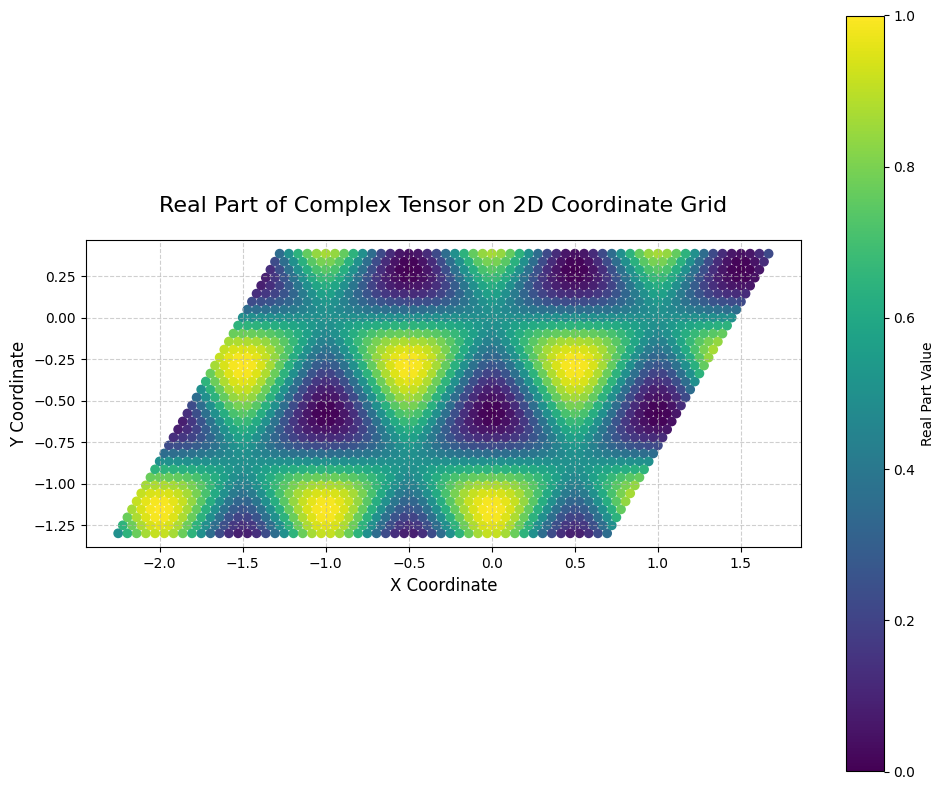

In [18]:
plot_real_part_on_2d_grid_2d(new_vals, new_momentum)

In [126]:
def grid_data_by_sorting(
    complex_array: np.ndarray,
    coordinates: np.ndarray,
    grid_shape: tuple[int, int]
) -> tuple[np.ndarray, np.ndarray]:
    """
    Reshapes a 1D complex array and its coordinates into a 2D grid.

    The arrays are reordered by sorting the coordinates lexicographically 
    (by y-coordinate, then by x-coordinate) before reshaping. This ensures
    that the element with the smallest (y, x) coordinate ends up at grid
    position (0, 0).

    Args:
        complex_array: A 1D NumPy array of complex numbers.
        coordinates: A 2D NumPy array of shape (n, 2) where n is the length
                     of complex_array. The columns represent the (x, y)
                     coordinates for each element.
        grid_shape: A tuple (n_rows, n_cols) for the desired output shape.
                    For example, (18, 18).

    Returns:
        A tuple containing:
        - grid_values (np.ndarray): A 2D array of complex data.
        - grid_coords (np.ndarray): A 3D array of shape (n_rows, n_cols, 2)
                                    containing the corresponding coordinates.
        
    Raises:
        ValueError: If the input arrays have incorrect dimensions or if the
                    number of elements does not match the grid shape.
    """
    # --- 1. Data Validation ---
    n_elements = len(complex_array)
    n_rows, n_cols = grid_shape

    if n_elements != coordinates.shape[0]:
        raise ValueError(
            "Length of `complex_array` must match the number of rows in `coordinates`."
        )
    if n_elements != n_rows * n_cols:
        raise ValueError(
            f"The number of elements ({n_elements}) does not match the "
            f"product of the grid shape dimensions ({n_rows * n_cols})."
        )
    if complex_array.ndim != 1:
        raise ValueError("Input `complex_array` must be 1-dimensional.")
    if coordinates.ndim != 2 or coordinates.shape[1] != 2:
        raise ValueError("Input `coordinates` must have shape (n, 2).")

    # --- 2. Find the Sorting Order ---
    # np.lexsort sorts using the last array as the primary key.
    # We want to sort by y (row), then by x (column).
    # So we provide the coordinates as (x_coords, y_coords).
    x_coords = coordinates[:, 0]
    y_coords = coordinates[:, 1]
    
    sorted_indices = np.lexsort((x_coords, y_coords))

    # --- 3. Apply the Sort and Reshape ---
    # Reorder the original complex array and coordinates array using the same indices.
    sorted_complex_array = complex_array[sorted_indices]
    sorted_coordinates = coordinates[sorted_indices]
    
    # Reshape the now-ordered arrays into their final grid shapes.
    grid_values = sorted_complex_array.reshape(grid_shape)
    grid_coords = sorted_coordinates.reshape((n_rows, n_cols, 2))
    
    return grid_values, grid_coords

new_matrix, new_coords = grid_data_by_sorting(
    np.abs(OP_list[:, 0, 0]),
    BZindex,
    (18, 18)
)
print(new_matrix.shape)
print(new_coords.shape)

(18, 18)
(18, 18, 2)


In [ ]:
# new_matrix = np.flip(new_matrix, axis=0)
# new_coords = np.flip(new_coords, axis=0)

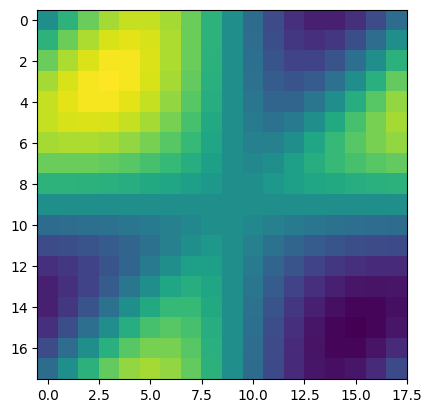

In [127]:
plt.imshow(new_matrix, interpolation='none')
plt.show()

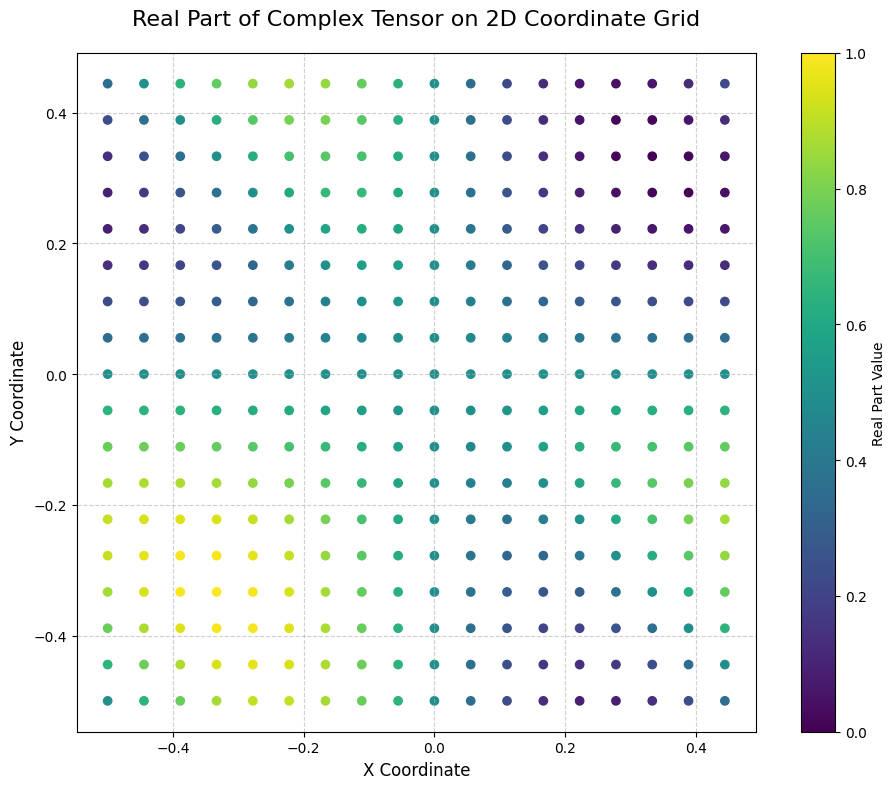

In [128]:
plot_real_part_on_2d_grid_2d(new_matrix.flatten(), new_coords.reshape(-1, 2))

In [129]:
FT_matrix = np.fft.fft2(new_matrix, norm="ortho")
# FT_matrix = np.fft.fftshift(FT_matrix)
FT_matrix = np.abs(FT_matrix)

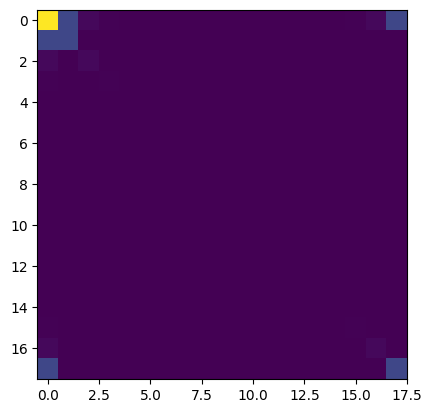

In [130]:
plt.imshow(np.abs(FT_matrix), interpolation='none')
plt.show()

In [131]:
for i in range(18):
    for j in range(18):
        x = i
        y = j

        new_coords[i, j] = np.array([
            (x - (0.5 * y)),
            (np.sqrt(3) / 2) * y
        ])

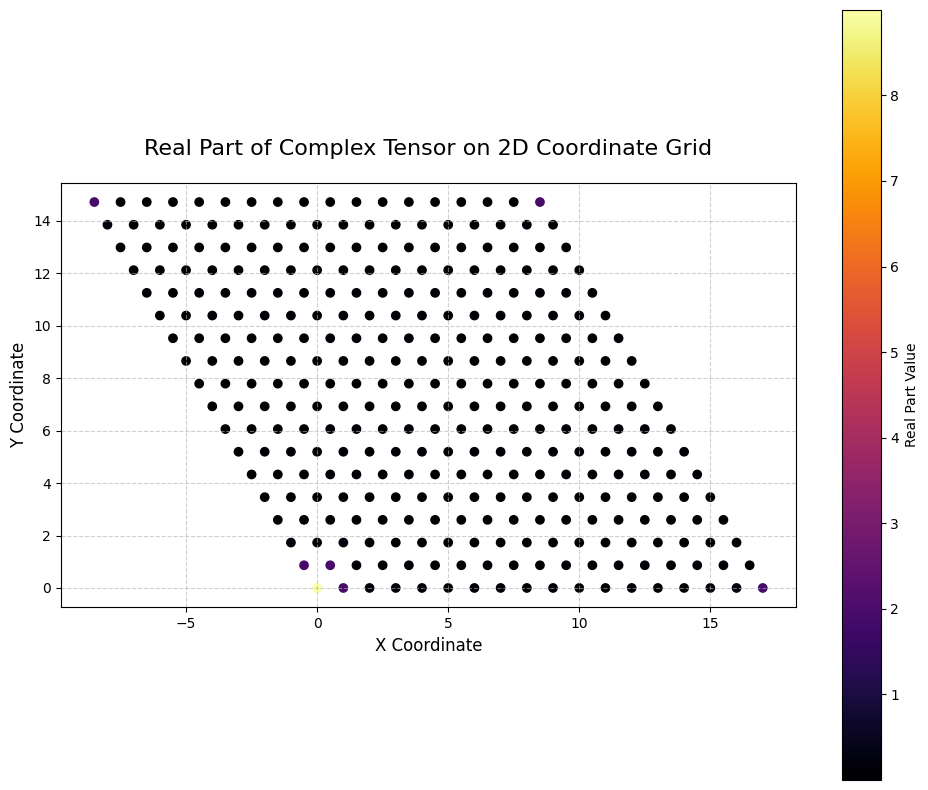

In [132]:
plot_real_part_on_2d_grid_2d(np.abs(FT_matrix).flatten(), new_coords.reshape(-1, 2), cmap = "inferno")

In [133]:
patched_coords = np.concatenate([
    new_coords.reshape(-1, 2) + np.array([0, 0]),
    new_coords.reshape(-1, 2) + np.array([18, 0]),
    new_coords.reshape(-1, 2) + np.array([-18, 0]),
    new_coords.reshape(-1, 2) + np.array([9, -9 * np.sqrt(3)]),
    new_coords.reshape(-1, 2) + np.array([27, -9 * np.sqrt(3)]),
    new_coords.reshape(-1, 2) + np.array([-9, -9 * np.sqrt(3)]),
], axis = 0)

patched_vals = np.tile(np.abs(FT_matrix).flatten(), (6))

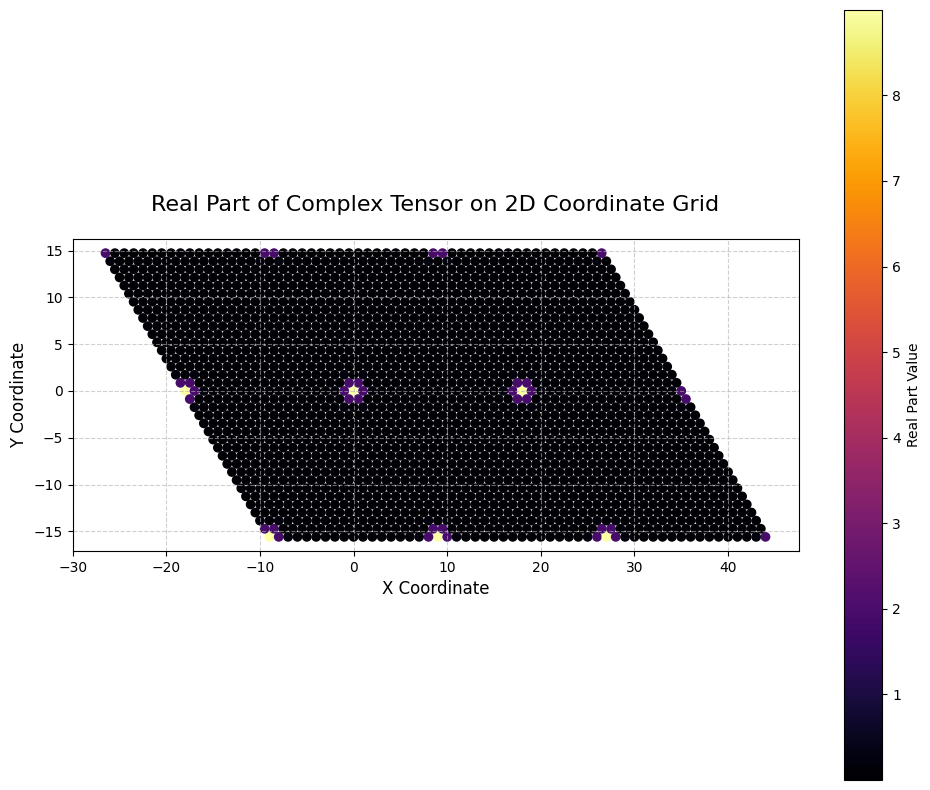

In [134]:
plot_real_part_on_2d_grid_2d(patched_vals, patched_coords, cmap = "inferno")

In [2]:
def reformat_matrices_3x3(array: np.ndarray) -> np.ndarray:
    # array should be of shape (L^2, 18)
    # first, convert back to complex
    real_part = array[:, :9]
    imag_part = array[:, 9:]
    array = real_part + (1j * imag_part)
    array = array.astype(np.complex128)

    # array should now be complex of shape (L^2, 9)
    # need to reshape to (3, 3, L^2)
    L_square = array.shape[0]
    array = array.reshape(L_square, 3, 3)
    array = np.permute_dims(array, axes=(1, 2, 0))
    
    return array

In [ ]:
parse_3x3_dataset(
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_6_y_6_f1_1_0_f2_0_1_xrefine_6_yrefine_6_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8_10K/HF_initial_data.h5",
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_6_y_6_f1_1_0_f2_0_1_xrefine_6_yrefine_6_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8_10K/HF_results_data.h5",
    "test.h5"
)

In [ ]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/test.h5", 'r') as f:
    print(f['dataset'][0])

In [7]:
# helper function to process LxL 310x310 matrices
def make_310x310_matrix(array: np.ndarray, cutoff) -> np.ndarray:
    # array should be of shape (310, 310, LxL)
    array = array[:cutoff, :cutoff, :]
    L_square = array.shape[-1]
    array = np.permute_dims(array, axes=(2, 0, 1))
    array = array.reshape(L_square, -1)
    array = np.concatenate([array.real, array.imag], axis=-1, dtype=np.float32)
    
    # combine the matrices into one array
    return array

# function to parse the .h5 files from the 310x310 code into a dataset
def parse_310x310_dataset(input_filename: str, output_filename: str, dataset_loc: str, cutoff = 70, num_samples = -1):

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        # get number of samples
        if (num_samples == -1):
            input_indices = list(in_file.keys())
            num_samples = len(input_indices)
        with h5py.File(output_filename, "r") as out_file:
            # first get seq_len
            seq_len = out_file['1']['OP_list_plane_wave'][()].shape[-1]
            with h5py.File(dataset_loc, "w") as f:
                embed_dim = (cutoff ** 2) * 2
                f.create_dataset(name="dataset", shape=(num_samples, 2, seq_len, embed_dim), dtype=np.float32)
                for i in range(1, num_samples + 1):
                    print(f"\rIndex: {i}", end='', flush=True)
                    try:
                        f['dataset'][i-1] = np.array(
                                [
                                    make_310x310_matrix(in_file[str(i)]['OP_list_plane_wave'][()], cutoff),
                                    make_310x310_matrix(out_file[str(i)]['OP_list_plane_wave'][()], cutoff),
                                ]
                            )
                    except (KeyError, OSError, IndexError) as e:
                        print(f"Error reading {i}: {e}")
                        continue

In [10]:
def reformat_matrices_310x310(array: np.ndarray, cutoff: int) -> np.ndarray:
    # array should be of shape (L^2, 2*cutoff^2)
    half_size = (cutoff**2)
    # first, convert back to complex
    real_part = array[:, :half_size]
    imag_part = array[:, half_size:]
    array = real_part + (1j * imag_part)
    array = array.astype(np.complex128)

    # array should now be complex of shape (L^2, cutoff^2)
    # need to reshape to (cutoff, cutoff, L^2) -> (310, 310, L^2)
    L_square = array.shape[0]
    array = array.reshape(L_square, cutoff, cutoff)
    array = np.permute_dims(array, axes=(1, 2, 0))

    empty = np.zeros((310, 310, L_square), dtype=np.complex128)
    empty[:cutoff, :cutoff, :] = array
    
    return empty

def postprocess_matrices_310x310(output: torch.tensor, cutoff: int = 70) -> np.ndarray:
    # output should be of shape (batch_size, L^2, 2*cutoff^2)
    # convert to NumPy array
    output = output.numpy()

    new_list = []

    # iterate over the new array
    for i in range(len(output)):
        new_list.append(reformat_matrices_310x310(output[i], cutoff))
    
    new_list = np.array(new_list)
    return new_list

In [2]:
# helper function to convert sequences of 4x4 matrices into sequence of flattened 32-dimensional vectors
def make_4x4_matrix(array: np.ndarray) -> np.ndarray:
    # add the flattened 4x4 matrices to a list
    matrix_list = []
    for i in range(array.shape[-2]):
        for j in range(array.shape[-1]):
            flattened_matrix = array[:, :, i, j].flatten()
            combined_matrix = np.concatenate([flattened_matrix.real, flattened_matrix.imag], dtype=np.float32)
            matrix_list.append(combined_matrix)

    # combine the matrices into one array
    return np.array(matrix_list)


# function to parse the .h5 files from the 4x4 code into a dataset
def parse_4x4_dataset(input_filename: str, output_filename: str, num_samples=-1):
    arr_list = []

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        input_indices = list(in_file.keys())
        # in case we want the whole dataset
        if num_samples == -1:
            num_samples = len(input_indices)
        with h5py.File(output_filename, "r") as out_file:
            for i in range(1, num_samples + 1):
                try:
                    arr_list.append(
                        np.array(
                            [
                                make_4x4_matrix(in_file[f"P_initial_{i}"][()]),
                                make_4x4_matrix(out_file[f"P_HF_result_{i}"][()]),
                            ]
                        )
                    )
                except (KeyError, OSError, IndexError) as e:
                    print(f"Error reading {i}: {e}")
                    continue

    # convert to NumPy multidimensional array -> PyTorch Tensor
    dataset = np.array(arr_list)
    return torch.from_numpy(dataset)

In [ ]:
for L in [32, 34, 36, 38, 42, 44, 46, 48]:
    dataset = parse_4x4_dataset(
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_{L}_U_1_number_of_random_initials_1000_filling_1/P_HF_initial.h5",
        f"/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_{L}_U_1_number_of_random_initials_1000_filling_1/P_HF_result.h5"
    )
    print(dataset.shape)
    torch.save(dataset, f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_datasets3/filling_1/test_{L}x{L}.pt")

In [8]:
filenames = [
    "/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_50_U_1_number_of_random_initials_200_filling_1_index2",
    "/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_50_U_1_number_of_random_initials_200_filling_1_index3",
    "/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_50_U_1_number_of_random_initials_200_filling_1_index4",
    "/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_50_U_1_number_of_random_initials_200_filling_1_index5",
    "/blue/yujiabin/awwab.azam/hartree-fock-code/four_band_model_tunable_interaction_range/filling_1/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_50_U_1_number_of_random_initials_1000_filling_1"
]

tensor_list = []

for filename in filenames:
    ds1 = parse_4x4_dataset(
            f"{filename}/P_HF_initial.h5",
            f"{filename}//P_HF_result.h5"
        )
    tensor_list.append(ds1)

combined_50x50 = torch.cat(tensor_list, dim=0)
print(combined_50x50.shape)

Error reading 221: "Unable to synchronously open object (object 'P_HF_result_221' doesn't exist)"
torch.Size([1020, 2, 2500, 32])


In [11]:
def reformat_4x4_matrices(array: np.ndarray) -> np.ndarray:
    # array should be of shape (L^2, 32)
    # first, convert back to complex
    real_part = array[:, :16]
    imag_part = array[:, 16:]
    array = real_part + (1j * imag_part)
    array = array.astype(np.complex128)

    # array should now be complex of shape (L^2, 16)
    # need to reshape to (4, 4, L, L)
    L_square = array.shape[0]
    L = int(np.sqrt(L_square))
    new_arr = np.zeros((4, 4, L, L), dtype=np.complex128)
    for index in range(L_square):
        i = index // L
        j = index % L
        new_arr[:, :, i, j] = array[index].reshape(4, 4)
    return new_arr


def postprocess_matrices_4x4(output: torch.tensor) -> np.ndarray:
    # output should be of shape (batch_size, L^2, 32)
    # convert to NumPy array
    output = output.numpy()

    new_list = []

    # iterate over the new array
    for i in range(len(output)):
        new_list.append(reformat_4x4_matrices(output[i]))
    
    new_list = np.array(new_list)
    return new_list

In [2]:
def reformat_matrices(array: np.ndarray) -> np.ndarray:
    # array should be of shape (L^2, 32)
    # first, convert back to complex
    real_part = array[:, :16]
    imag_part = array[:, 16:]
    array = real_part + (1j * imag_part)
    array = array.astype(np.complex128)

    # array should now be complex of shape (L^2, 16)
    # need to reshape to (4, 4, L, L)
    L_square = array.shape[0]
    L = int(np.sqrt(L_square))
    new_arr = np.zeros((4, 4, L, L), dtype=np.complex128)
    for index in range(L_square):
        i = index // L
        j = index % L
        new_arr[:, :, i, j] = array[index].reshape(4, 4)
    return new_arr


def postprocess(output: torch.tensor) -> np.ndarray:
    # output should be of shape (batch_size, L^2, 32)
    # convert to NumPy array
    output = output.numpy()

    new_list = []

    # iterate over the new array
    for i in range(len(output)):
        new_list.append(reformat_matrices(output[i]))
    
    new_list = np.array(new_list)
    return new_list

In [3]:
sqrt_MSEs = []

for L in [9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 34, 35, 36, 38, 42, 44, 45, 46, 48]:
    # load results and test it
    pred = torch.load(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/results/output_filling1_6x6_8x8_trial1_july4_{L}x{L}.pt", weights_only=True, map_location=torch.device('cpu'))
    Y = torch.load(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_datasets3/filling_1/test_{L}x{L}.pt", weights_only=True, map_location=torch.device('cpu'))[:, 1, :, :]

    loss_fn = torch.nn.MSELoss()
    pred = pred.to("cpu")
    Y = Y.to("cpu")
    error = math.sqrt(loss_fn(pred, Y).item())
    sqrt_MSEs.append(error)
    print(f"Sqrt of MSE is {error:.4f}")

    # convert back to original format
    output = postprocess(pred)
    print(output.shape)
    print(output.dtype)
    output = np.stack((output.real, output.imag), axis=1)
    print(output.shape)
    print(output.dtype)

    # save to H5 file
    with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_datasets3/filling_1/output_filling1_6x6_8x8_trial1_july4_{L}x{L}.h5", mode = 'w') as f:
        for i, array in enumerate(output):
            f.create_dataset(f"P_ML_{i+1}", data=array)

Sqrt of MSE is 0.0147
(1000, 4, 4, 9, 9)
complex128
(1000, 2, 4, 4, 9, 9)
float64
Sqrt of MSE is 0.0114
(1000, 4, 4, 10, 10)
complex128
(1000, 2, 4, 4, 10, 10)
float64
Sqrt of MSE is 0.0141
(1000, 4, 4, 12, 12)
complex128
(1000, 2, 4, 4, 12, 12)
float64
Sqrt of MSE is 0.0183
(1000, 4, 4, 14, 14)
complex128
(1000, 2, 4, 4, 14, 14)
float64
Sqrt of MSE is 0.0192
(1000, 4, 4, 15, 15)
complex128
(1000, 2, 4, 4, 15, 15)
float64
Sqrt of MSE is 0.0203
(1000, 4, 4, 16, 16)
complex128
(1000, 2, 4, 4, 16, 16)
float64
Sqrt of MSE is 0.0237
(1000, 4, 4, 18, 18)
complex128
(1000, 2, 4, 4, 18, 18)
float64
Sqrt of MSE is 0.0289
(1000, 4, 4, 22, 22)
complex128
(1000, 2, 4, 4, 22, 22)
float64
Sqrt of MSE is 0.0313
(1000, 4, 4, 24, 24)
complex128
(1000, 2, 4, 4, 24, 24)
float64
Sqrt of MSE is 0.0326
(1000, 4, 4, 25, 25)
complex128
(1000, 2, 4, 4, 25, 25)
float64
Sqrt of MSE is 0.0338
(1000, 4, 4, 26, 26)
complex128
(1000, 2, 4, 4, 26, 26)
float64
Sqrt of MSE is 0.0360
(1000, 4, 4, 28, 28)
complex128
(100

In [4]:
for L in [9, 10, 12, 14, 15, 16, 18, 22, 24, 25, 26, 28, 32, 34, 35, 36, 38, 42, 44, 45, 46, 48]:
    # load results to find number of samples
    pred = torch.load(f"/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/results/output_filling1_6x6_8x8_trial1_july4_{L}x{L}.pt", weights_only=True, map_location=torch.device('cpu'))
    num_samples = pred.shape[0]
    print(f"bash bash_run {L} {num_samples}")

bash bash_run 9 1000
bash bash_run 10 1000
bash bash_run 12 1000
bash bash_run 14 1000
bash bash_run 15 1000
bash bash_run 16 1000
bash bash_run 18 1000
bash bash_run 22 1000
bash bash_run 24 1000
bash bash_run 25 1000
bash bash_run 26 1000
bash bash_run 28 1000
bash bash_run 32 1000
bash bash_run 34 907
bash bash_run 35 941
bash bash_run 36 735
bash bash_run 38 607
bash bash_run 42 390
bash bash_run 44 372
bash bash_run 45 336
bash bash_run 46 251
bash bash_run 48 203


In [ ]:
def parse_datasets(dims: List[int], size: int, src_file, dataset_file):
    for dim in dims:
        prefix = src_file.format(**locals())
        input_filename = prefix + "P_HF_initial.h5"
        output_filename = prefix + "P_HF_result.h5"
        dataset = parse_4x4_dataset(input_filename, output_filename)
        torch.save(dataset, dataset_file.format(**locals()))
        print(f"Dataset shape: {dataset.shape}")
    print("Done!")

In [ ]:
# use function to store tensors for simple datasets
dims = list(range(10, 51, 5))
size = 1000
parse_datasets(
    dims,
    size,
    "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_4_band_model_tunable_interaction_range_HF_For_ML/L_{dim}_U_1_number_of_random_initials_{size}_filling_1_cpus_8/",
    "/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_datasets3/filling_1/test_{dim}x{dim}.pt",
)

In [3]:
def plot_band_structure(arr: np.ndarray) -> None:
    x = np.arange(0, len(arr))
    plt.scatter(x, arr.real)
    plt.show()


def filter_banded_complex(arr, threshold=50, range_width=1e-4):
    """
    Filter complex array to keep values where real part has at least threshold entries
    within range_width of each other.

    Parameters:
    arr: numpy array of complex numbers
    threshold: minimum number of values in a band (default: 50)
    range_width: width of the band to consider (default: 1e-4)

    Returns:
    filtered numpy array
    """
    # Extract real parts
    real_parts = np.real(arr)

    # Initialize mask for values to keep
    mask = np.zeros_like(arr, dtype=bool)

    # For each value, count how many others are within range_width
    for i, val in enumerate(real_parts):
        # Count values within range_width of current value
        in_range = (
            np.abs(real_parts - val) < range_width / 2
        )  # should I divide by 2 here?
        if np.sum(in_range) >= threshold:
            mask[i] = True

    # Return filtered array
    return arr[mask]


# function to parse the .h5 files from the new code with MxM I/O matrices into a dataset
def parse_M_matrices(input_filename: str, output_filename: str, num_samples=-1):
    arr_list = []

    # add each group of matrices to the list
    with h5py.File(input_filename, "r") as in_file:
        # in case we want the whole dataset
        if num_samples == -1:
            num_samples = len(list(in_file.keys()))
        with h5py.File(output_filename, "r") as out_file:
            # first, get all the energies
            energy_list = []
            for i in range(1, num_samples + 1):  # i should go from 1 to 10000
                energy_list.append(out_file[f"HF_energy_per_unit_cell_{i}"][()])

            # now process energy_list
            energy_list = np.array(energy_list)
            energy_list = energy_list[energy_list.real < 1.5]
            energy_list = filter_banded_complex(energy_list)
            print(energy_list.shape)
            plot_band_structure(energy_list)

            # now iterate once again to get only the values with the energies we want
            for i in range(1, num_samples + 1):
                # get the energy for this index
                energy = out_file[f"HF_energy_per_unit_cell_{i}"][()]
                if energy in energy_list:
                    arr_list.append(
                        [
                            in_file[f"P_initial_{i}"][()],
                            out_file[f"P_HF_result_{i}"][()],
                        ]
                    )

    # convert to NumPy multidimensional array -> PyTorch Tensor
    dataset = np.array(arr_list)
    return torch.from_numpy(dataset)

In [ ]:
input_filename = "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_4_band_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_6_U_1_number_of_random_initials_20000_occupied_72_cpus_64_trial2/P_HF_initial.h5"
output_filename = "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_4_band_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_6_U_1_number_of_random_initials_20000_occupied_72_cpus_64_trial2/P_HF_result.h5"
new_dataset = parse_M_matrices(input_filename, output_filename)
print(new_dataset.shape)

In [6]:
with h5py.File(output_filename, "r") as out_file:
    # first, get all the energies
    energy_list = []
    for i in range(1, 20_000 + 1):  # i should go from 1 to 10000
        energy_list.append(out_file[f"HF_energy_per_unit_cell_{i}"][()])

In [7]:
energy_list = np.array(energy_list)

In [8]:
min_energy = np.min(energy_list.real)
print(min_energy)

1.1254583776192502


In [9]:
print((np.abs(energy_list.real - min_energy) < 1e-4).sum())

96


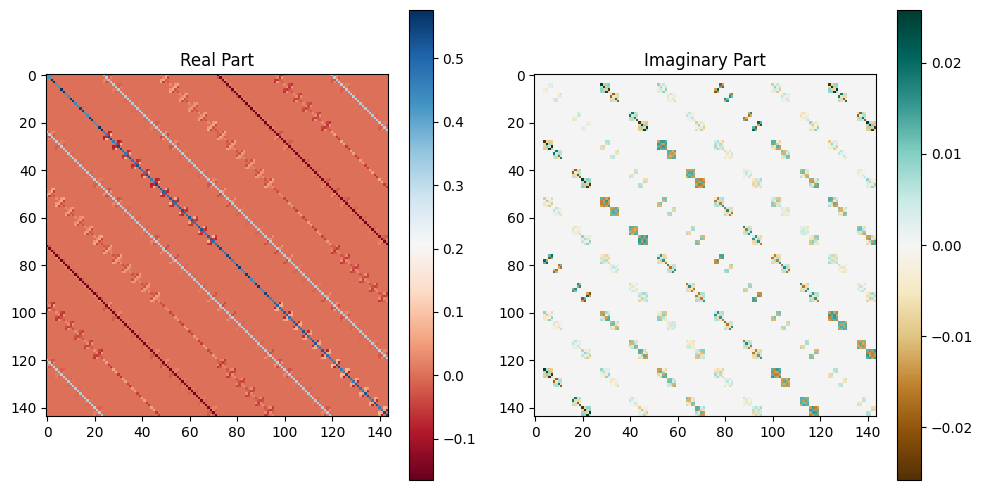

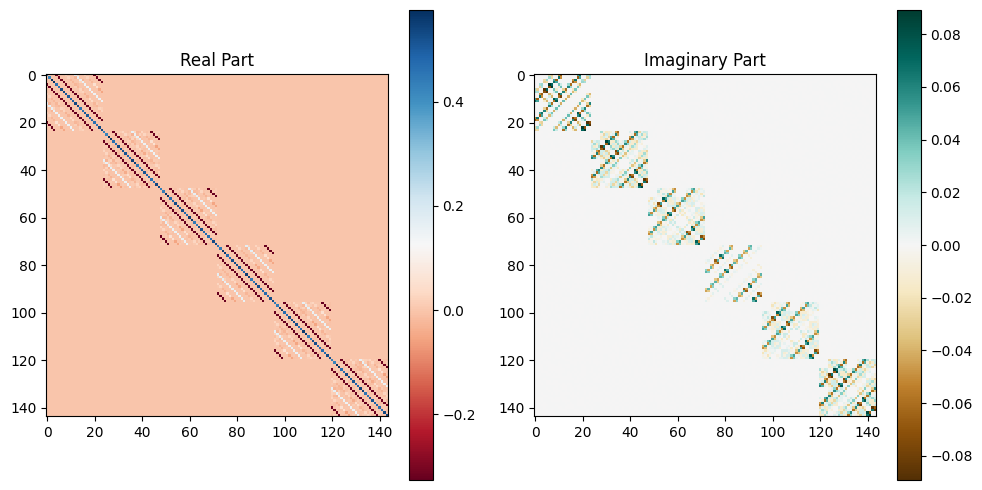

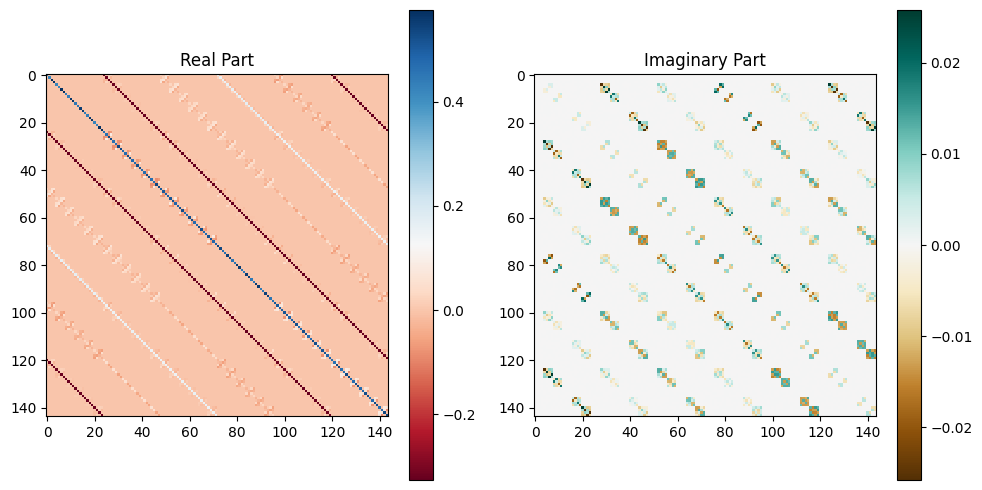

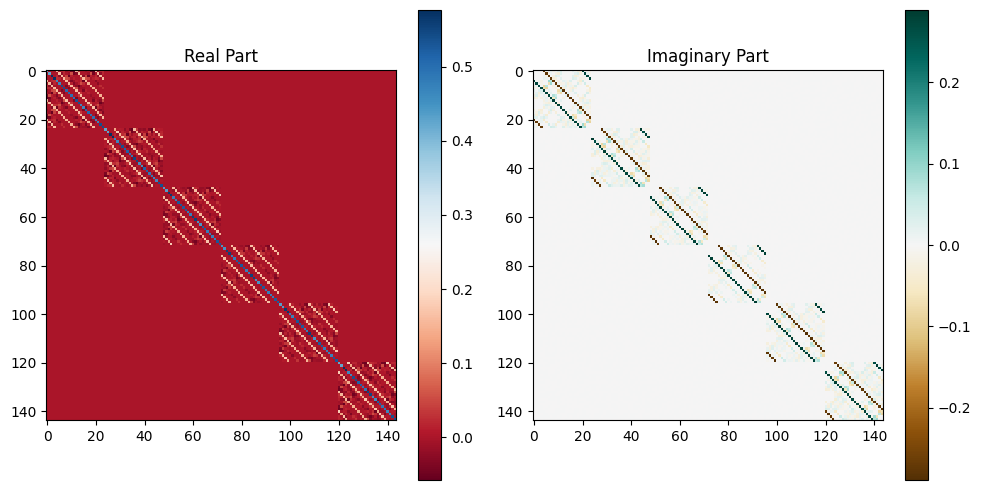

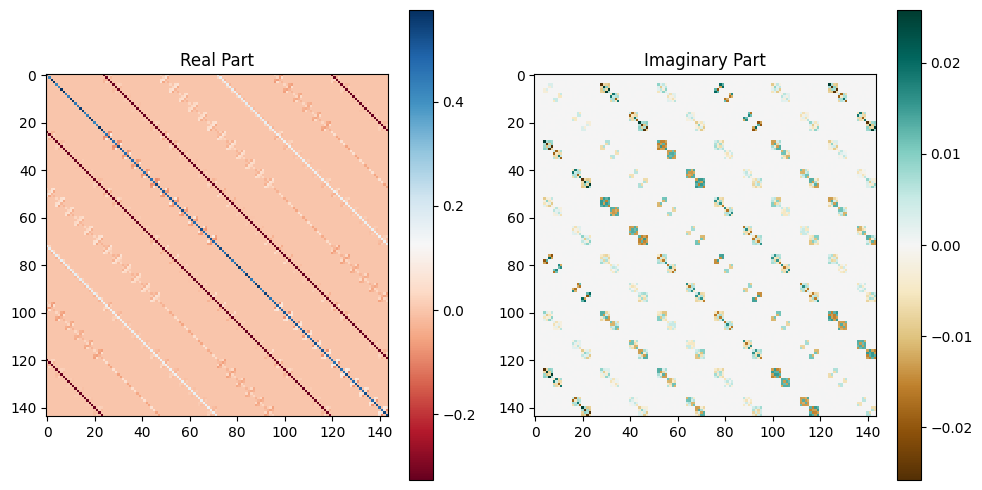

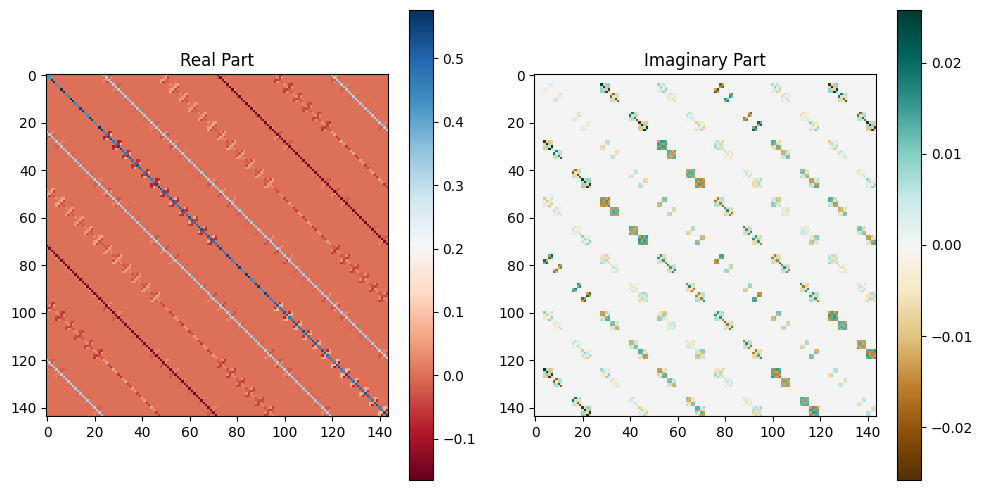

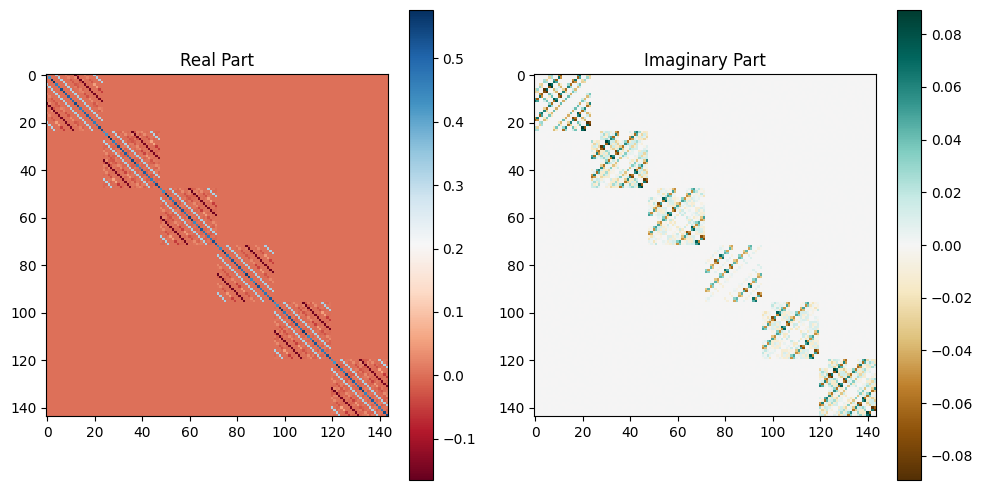

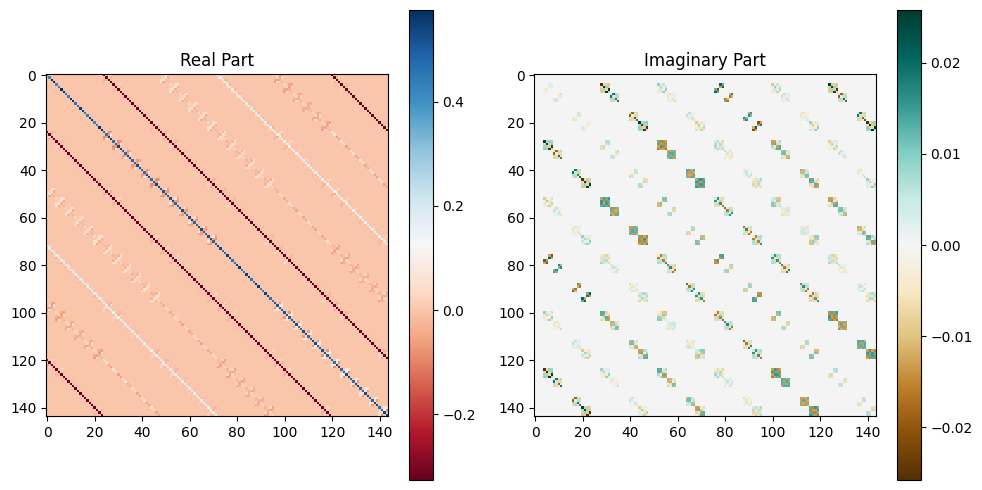

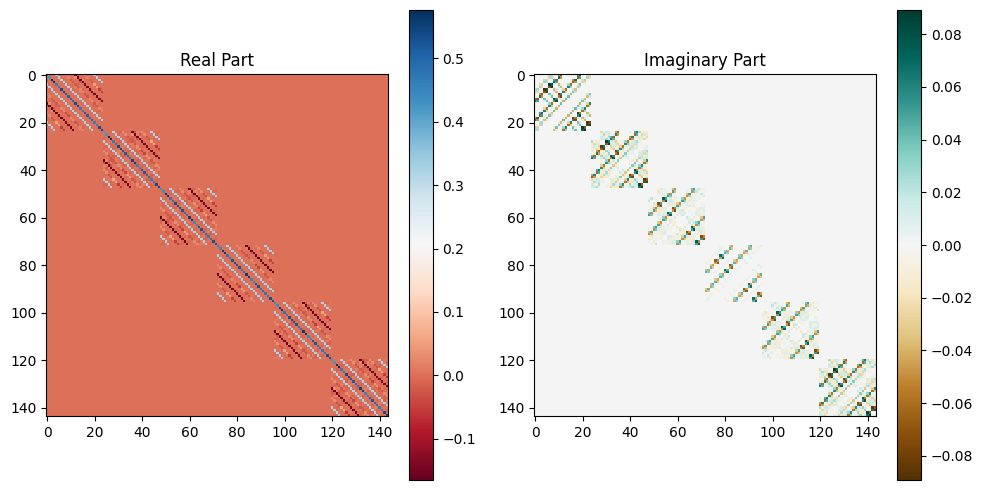

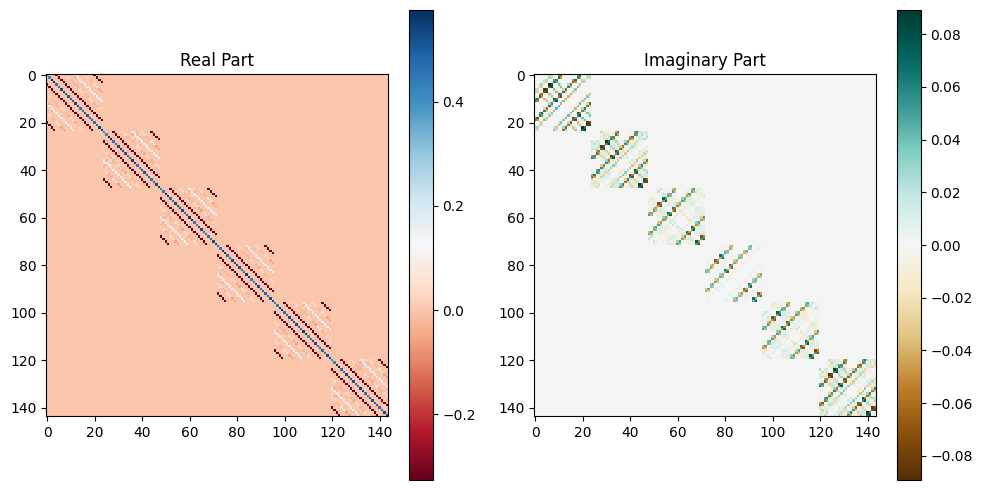

In [10]:
with h5py.File(output_filename, "r") as out_file:
    count = 0
    for i in range(1, 20_000 + 1):
        new_energy = out_file[f"HF_energy_per_unit_cell_{i}"][()].real
        if(np.abs(new_energy - min_energy) < 1e-4):
            plot_complex_matrix(np.transpose(out_file[f"P_HF_result_{i}"][()]))
            count += 1
        if count >= 10:
            break

In [6]:
# save to file
torch.save(
    new_dataset,
    "datasets/tunable_interaction_range_Trans_Breaking/trans_breaking_6x6_new.pt",
)

In [ ]:
# reshape dataset if using transformer
batch_size, _, four_L_square, four_L_square = new_dataset.shape
L_square = four_L_square // 4
new_dataset = new_dataset.reshape(batch_size, _, L_square, 4, L_square, 4).permute(0, 1, 2, 4, 3, 5).reshape(batch_size, _, L_square**2, 16)
new_dataset = torch.cat((new_dataset.real, new_dataset.imag), -1)
print(new_dataset.shape)
print(new_dataset.dtype)

torch.Size([17070, 2, 1296, 32])
torch.float64


In [4]:
output_filename="/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_4_band_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/L_6_U_1_number_of_random_initials_20000_occupied_72_cpus_64_trial2/P_HF_result.h5"
with h5py.File(output_filename, "r") as out_file:
            # first, get all the energies
            energy_list = []
            for i in range(1, 20001):  # i should go from 1 to 10000
                energy_list.append(out_file[f"HF_energy_per_unit_cell_{i}"][()])

            # now process energy_list
            energy_list = np.array(energy_list)
            print(np.min(energy_list))

(1.1254583776192502-6.545297104489863e-18j)


### Parse log files

In [2]:
def get_num_iterations(filenames):
    iterations = []
    for filename in filenames:
        with open(filename) as f:
            iteration_num = 0
            checking = False
            for line in f:
                # Check if "Iteration:" exists and extract the number
                match = re.search(r'Iteration:\s*(\d+)', line)
                if match:
                    checking = True
                    iteration_num = int(match.group(1))
                else:
                    if checking is True:
                        iterations.append(iteration_num)
                        print(f"Total number of iterations: {iteration_num}")
                        checking = False
                if len(iterations) == 1000:
                    break
    return iterations

In [21]:
def get_num_iterations_plane_waves(filenames, cutoff = None):
    iterations = []
    for filename in filenames:
        with open(filename) as f:
            iteration_num = 0
            for line in f:
                match = re.match(r"(\d+):", line)
                if match:
                    iteration_num = int(match.group(1))
                
                elif ("Initial Energy" in line) and (iteration_num > 1):
                    iterations.append(iteration_num)

                if cutoff is not None and len(iterations) == cutoff:
                    break
    return iterations

In [32]:
ML_iters = get_num_iterations_plane_waves(["/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_18_fourier_test/slurm-6822056.out"])
iters = get_num_iterations_plane_waves(["/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_tMoTe2_2BPV_HF/tMoTe2_L_18/data/HF_2BPV_tMoTe2_FH_3.89deg_data_for_HF_L_18_index_1/slurm-6341221.out"])

In [33]:
print((np.mean(iters) - np.mean(ML_iters)) / np.mean(iters))

0.6931084337349398


In [ ]:
filenames = [
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_testing_apr17/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_model_training_3x3_6x6_num_heads_8_epochs_120_fixed/slurm-65509946.out",
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_testing_apr17/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_model_training_3x3_6x6_num_heads_8_input_dim_64_epochs_120_fixed/slurm-65506024.out",
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_testing_apr17/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_model_training_6x6_9x9_num_heads_8_epochs_80_fixed/slurm-65506274.out",
    "/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_testing_apr17/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_model_training_6x6_9x9_num_heads_8_input_dim_64_epochs_80_fixed/slurm-65506275.out"
]

for f in filenames:
    ML_iters = get_num_iterations_plane_waves([f])[:486]
    ML_iters = get_num_iterations_plane_waves(["/orange/yujiabin/hartree-fock-archive/Band_Projected_In_PlaneWaves_archive/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_cpus_8/slurm-64982154.out"])[:486]
    print(f)
    print((np.mean(iters) - np.mean(ML_iters)) / np.mean(iters))

In [14]:
ML_iters = ML_iters[:200]

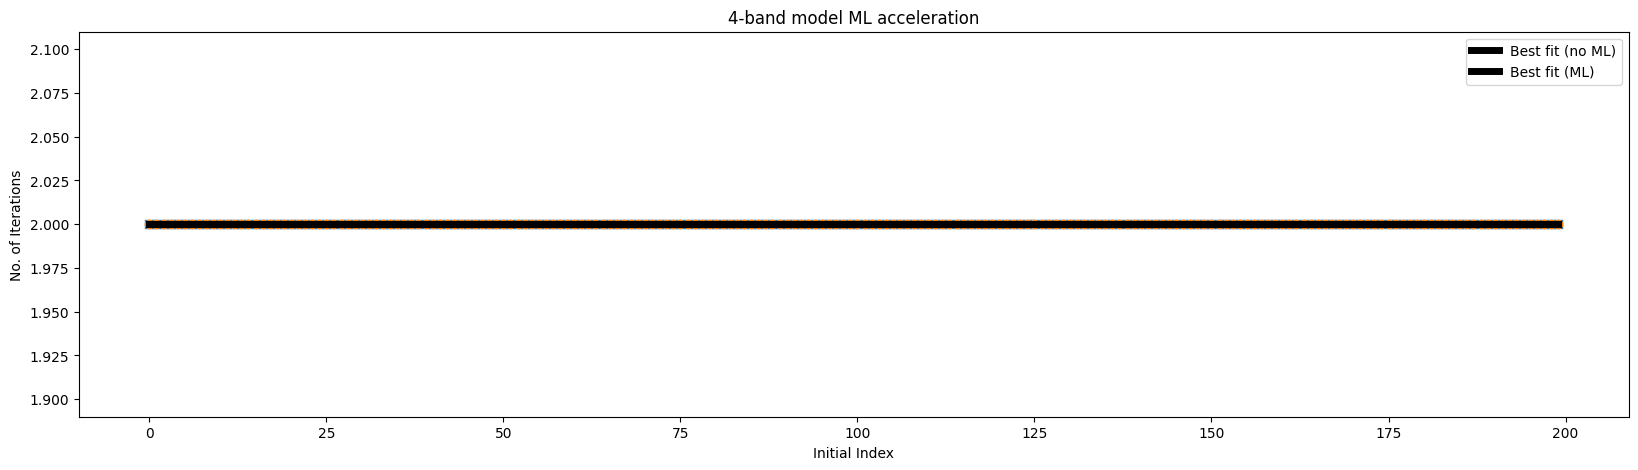

In [15]:
plt.figure(figsize=(20, 5))
domain = np.arange(200)
plt.scatter(domain, iters, marker="s")  # Plot the list with markers
plt.scatter(domain, ML_iters, marker="o")  # Plot the list with markers
plt.title("4-band model ML acceleration")
plt.xlabel("Initial Index")
plt.ylabel("No. of Iterations")
# Add lines of best fit for both series
z1 = np.polyfit(domain, iters, 1)
p1 = np.poly1d(z1)
plt.plot(domain, p1(domain), color='black', linewidth=5, label='Best fit (no ML)')

z2 = np.polyfit(domain, ML_iters, 1)
p2 = np.poly1d(z2)

plt.plot(domain, p2(domain), color='black', linewidth=5, label='Best fit (ML)')

plt.legend()
# Show the plot
plt.show()

In [16]:
print(np.mean(iters))
print(np.mean(ML_iters))

2.0
2.0


In [ ]:
filling1_iters = np.array(filling1_iters)

with h5py.File('/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/tunable_interaction_range_datasets3/filling_1/iterations.h5', 'w') as hf:
    hf.create_dataset('num_iters', data=filling1_iters)

generalization_vals = np.array([0.018734582177130303, 0.05174636560223726, 0.4092280574504437, 0.4475371623887153, 0.5584592706317479])
generalization_vals = generalization_vals * (0.0022809894289821386 ** 2)

with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/training_3x3_6x6_num_heads_8_input_dim_64_epochs_120/generalization_test.h5", 'w') as f:
    f.create_dataset("values", data = generalization_vals)

In [12]:
count = 400
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/70x70_model/truncate_test.h5", 'w') as out_file:       
    with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_CN_n+n_2DInt_HF_MatElement_k_shfit_JY_Band_Projected_HF_In_PlaneWaves/MatElements_2DInt_Background_Bands_1_3_Polarized_V_22_x_15_y_15_f1_1_0_f2_0_1_xrefine_15_yrefine_15_f1refine_1_0_f2refine_0_1_kshift_0.000_0.000_model_combined_c70_supersmall_may5/HF_results_data.h5", 'r') as in_file:
        for i in range(1, count + 1):
            sequence = in_file[str(i)]['OP_list_plane_wave'][()]
            empty = np.zeros((310, 310, 225), dtype=np.complex128)
            empty[:70, :70, :] = sequence[:70, :70, :]
            empty = np.stack([empty.real, empty.imag], axis=0)
            out_file.create_dataset(f"OP_plane_wave_ML_{i}", data=empty)
            print(f"\rIndex: {i}", end='', flush=True)

Index: 400

In [2]:
with h5py.File("/blue/yujiabin/awwab.azam/hartree-fock-code/datasets/3x3_model/dataset_6x6_100K.h5", 'r') as f:
    data = f['dataset'][()]

print(data.shape)

(100000, 2, 36, 18)


In [5]:
np.sum(data[0, 0, 0] != 0)

np.int64(9)